In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
#allow us to see all columns and rows w/out truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df.isnull().sum() / df.isnull().count() * 100

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
b

In [5]:
#fill in some missing values
df.lotfrontage.fillna(df.lotfrontage.median(), inplace=True)
#Alley NA's means there's no alley access
df.alley.fillna('No Access', inplace=True)
#basement NA's == no basement
df.bsmtqual.fillna('No Basement', inplace=True)
df.bsmtcond.fillna('No Basement', inplace=True)
df.bsmtexposure.fillna('No Basement', inplace=True)
df.bsmtfintype1.fillna('No Basement', inplace=True)
df.bsmtfintype2.fillna('No Basement', inplace=True)
#fireplace na means no fireplace
df.fireplacequ.fillna('No Fireplace', inplace=True)
#garage--see above
df.garagetype.fillna('No Garage', inplace=True)
df.garagefinish.fillna('No Garage', inplace=True)
df.garagequal.fillna('No Garage', inplace=True)
df.garagecond.fillna('No Garage', inplace=True)
df.garageyrblt.fillna('No Year', inplace=True)
#these are unique, but same as above
df.poolqc.fillna('No pool', inplace=True)
df.fence.fillna('No Fence', inplace=True)
df.miscfeature.fillna('None unique', inplace=True)
#masonry is either 0 or not there
df.masvnrtype.fillna('No masonry', inplace=True)
df.masvnrarea.fillna(0, inplace=True)

In [6]:
df.isnull().sum() / df.isnull().count() * 100

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.000000
lotarea          0.000000
street           0.000000
alley            0.000000
lotshape         0.000000
landcontour      0.000000
utilities        0.000000
lotconfig        0.000000
landslope        0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
bldgtype         0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
yearbuilt        0.000000
yearremodadd     0.000000
roofstyle        0.000000
roofmatl         0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrtype       0.000000
masvnrarea       0.000000
exterqual        0.000000
extercond        0.000000
foundation       0.000000
bsmtqual         0.000000
bsmtcond         0.000000
bsmtexposure     0.000000
bsmtfintype1     0.000000
bsmtfinsf1       0.000000
bsmtfintype2     0.000000
bsmtfinsf2       0.000000
bsmtunfsf        0.000000
totalbsmtsf 

Now that we've handled almost all missing values, let's work on some univariate analysis.

In [7]:
columns = df.columns.tolist()
columns.remove('id')
columns.remove('mssubclass')

In [8]:
for column in columns:
    print('{} -- {}'.format(column, df[column].nunique()))

mszoning -- 5
lotfrontage -- 110
lotarea -- 1073
street -- 2
alley -- 3
lotshape -- 4
landcontour -- 4
utilities -- 2
lotconfig -- 5
landslope -- 3
neighborhood -- 25
condition1 -- 9
condition2 -- 8
bldgtype -- 5
housestyle -- 8
overallqual -- 10
overallcond -- 9
yearbuilt -- 112
yearremodadd -- 61
roofstyle -- 6
roofmatl -- 8
exterior1st -- 15
exterior2nd -- 16
masvnrtype -- 5
masvnrarea -- 327
exterqual -- 4
extercond -- 5
foundation -- 6
bsmtqual -- 5
bsmtcond -- 5
bsmtexposure -- 5
bsmtfintype1 -- 7
bsmtfinsf1 -- 637
bsmtfintype2 -- 7
bsmtfinsf2 -- 144
bsmtunfsf -- 780
totalbsmtsf -- 721
heating -- 6
heatingqc -- 5
centralair -- 2
electrical -- 5
firstflrsf -- 753
secondflrsf -- 417
lowqualfinsf -- 24
grlivarea -- 861
bsmtfullbath -- 4
bsmthalfbath -- 3
fullbath -- 4
halfbath -- 3
bedroomabvgr -- 8
kitchenabvgr -- 4
kitchenqual -- 4
totrmsabvgrd -- 12
functional -- 7
fireplaces -- 4
fireplacequ -- 6
garagetype -- 7
garageyrblt -- 98
garagefinish -- 4
garagecars -- 5
garagearea -- 4

In [9]:
#split our variables into continuous and categorical/discrete columns
cat_cols = []
cont_cols = []

for column in columns:
    if (column[:4] != 'year' and df[column].nunique() < 100):
        cat_cols.append(column)
    else:
        cont_cols.append(column)     

#some minor changes from our rules
cat_cols.remove('screenporch')
cont_cols.append('screenporch')

cat_cols.remove('garageyrblt')

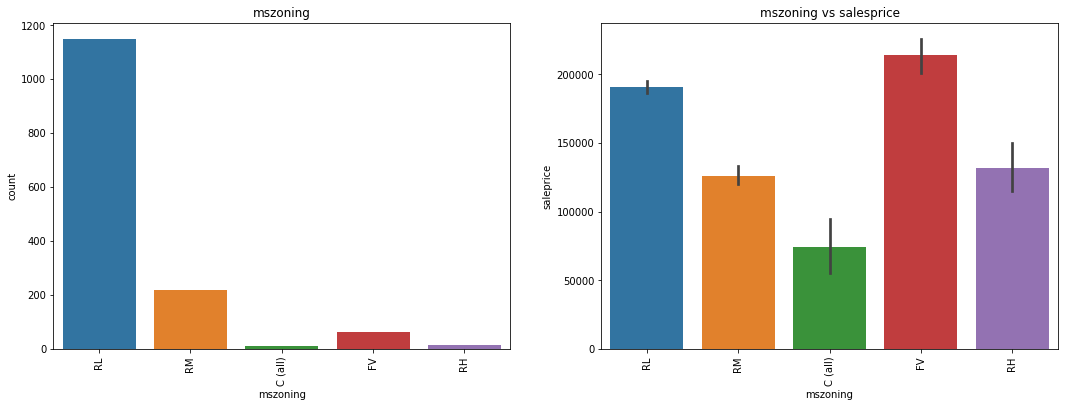

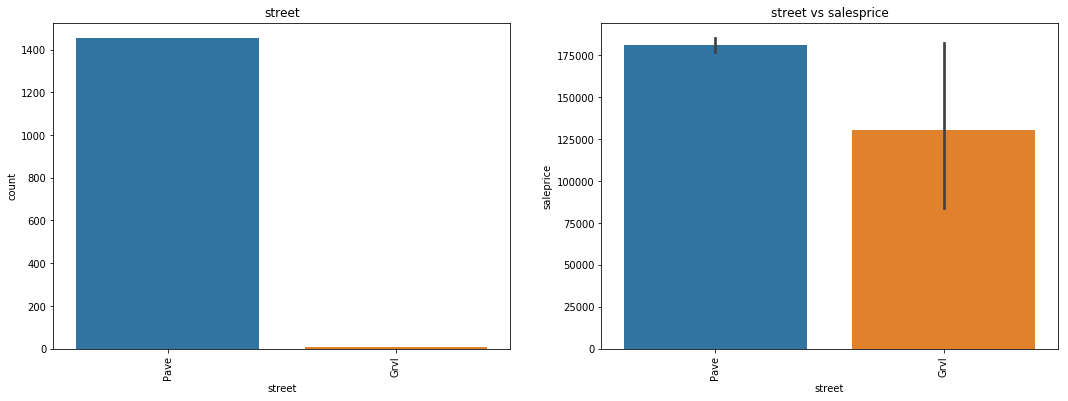

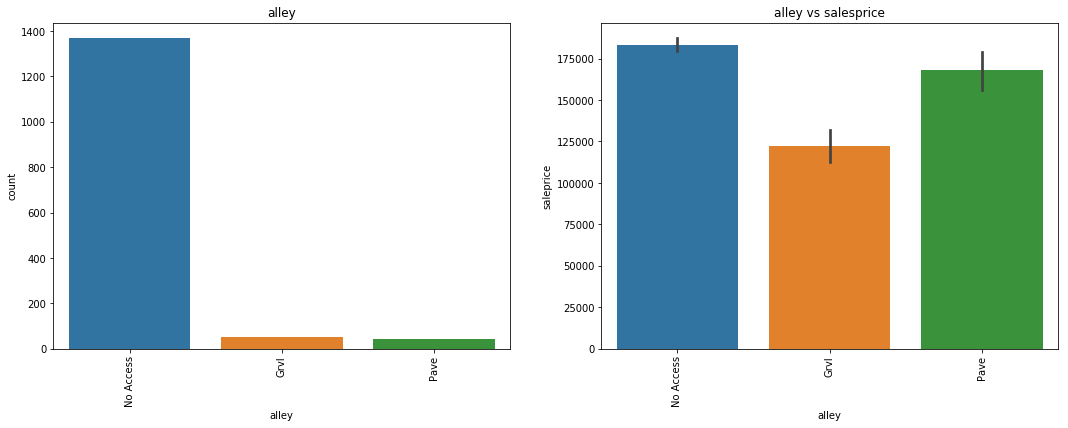

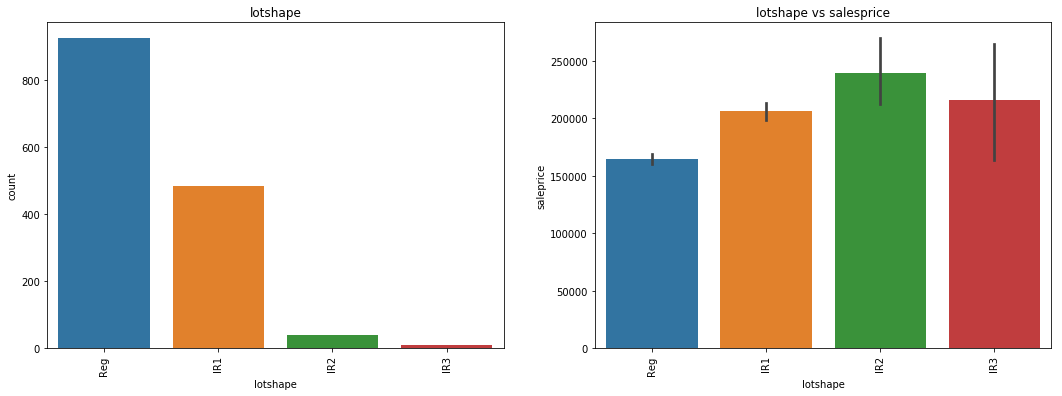

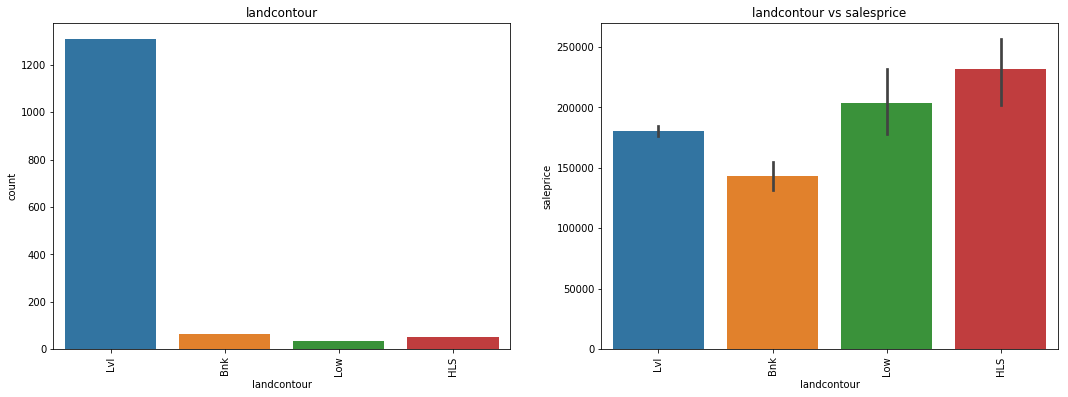

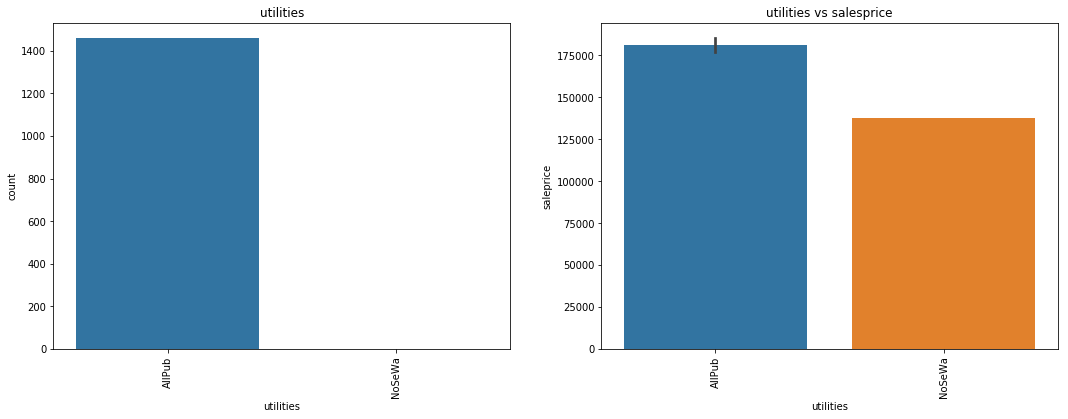

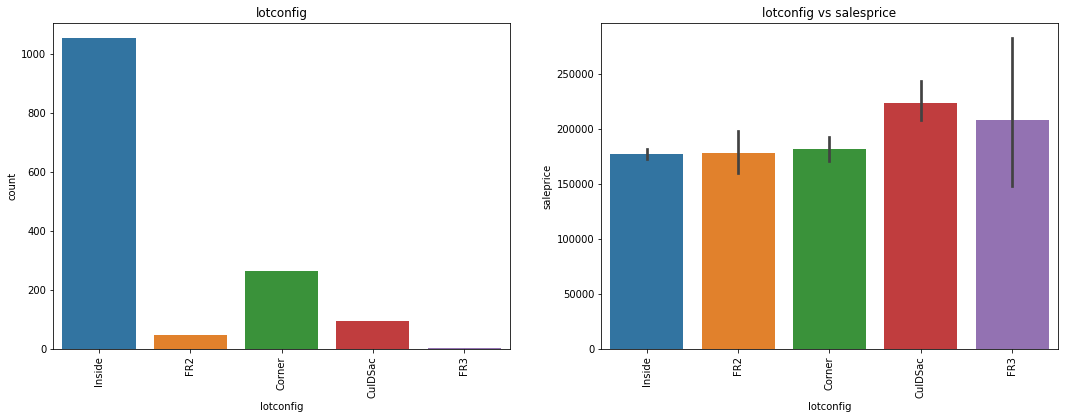

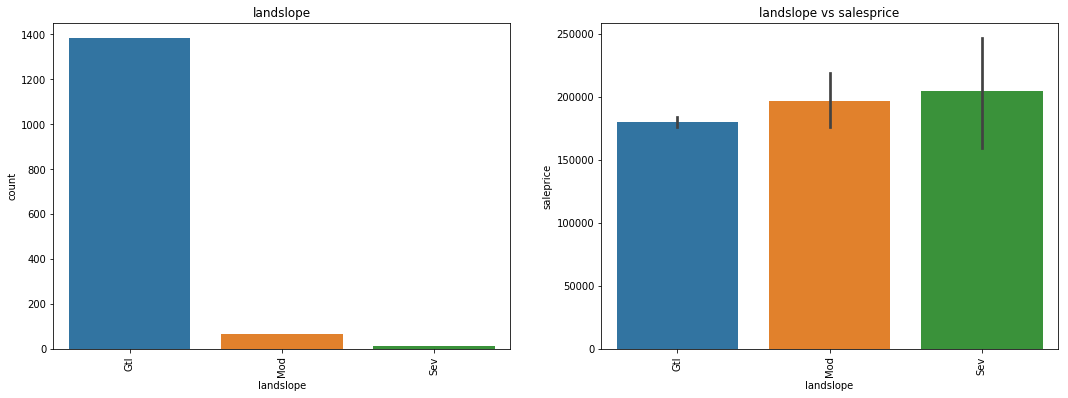

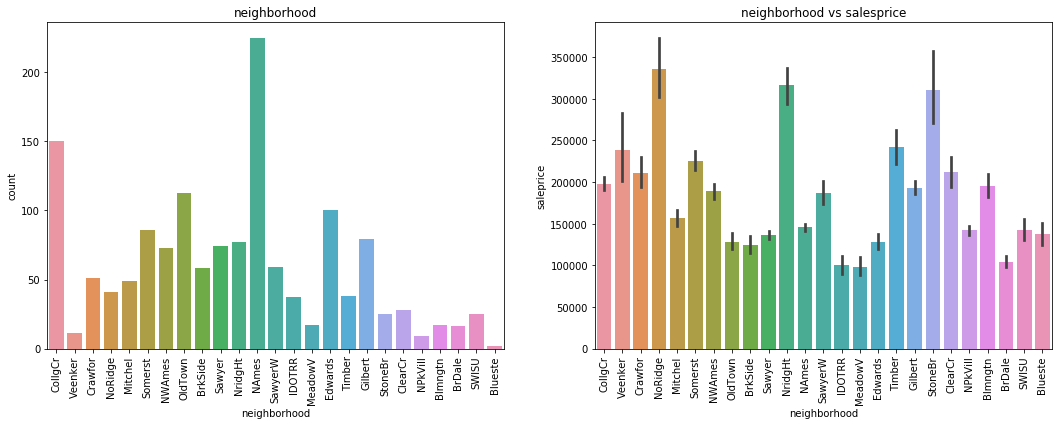

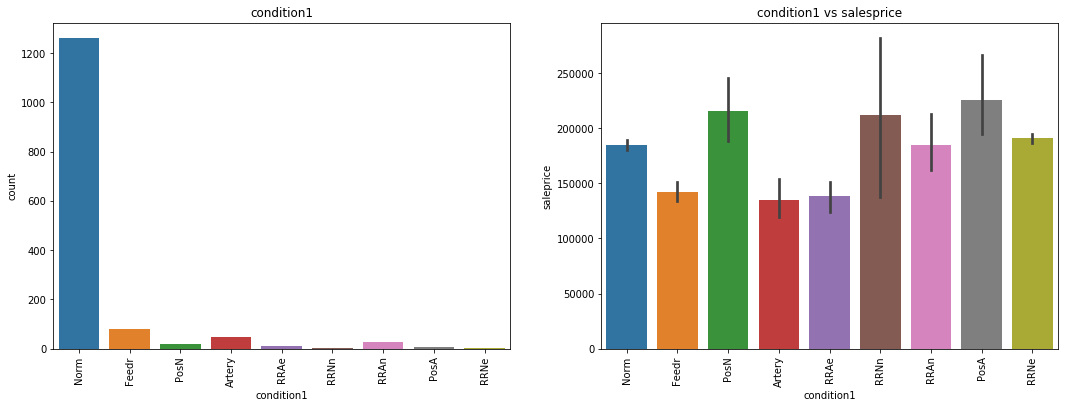

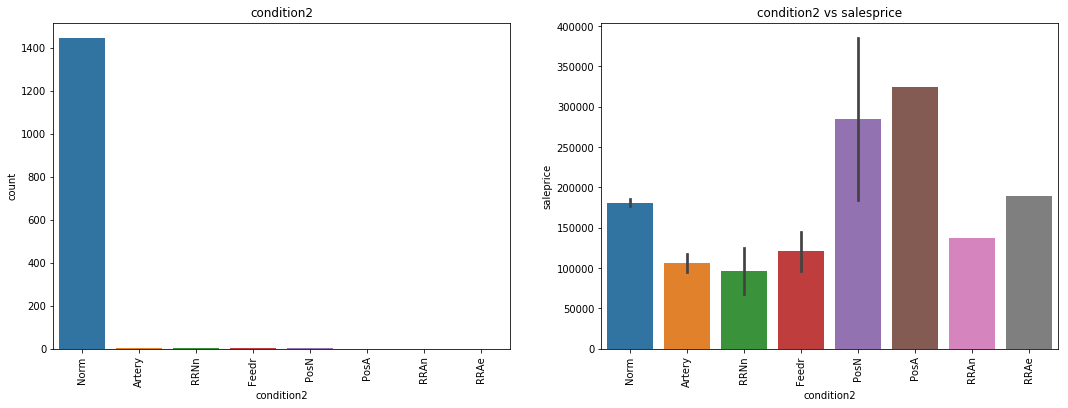

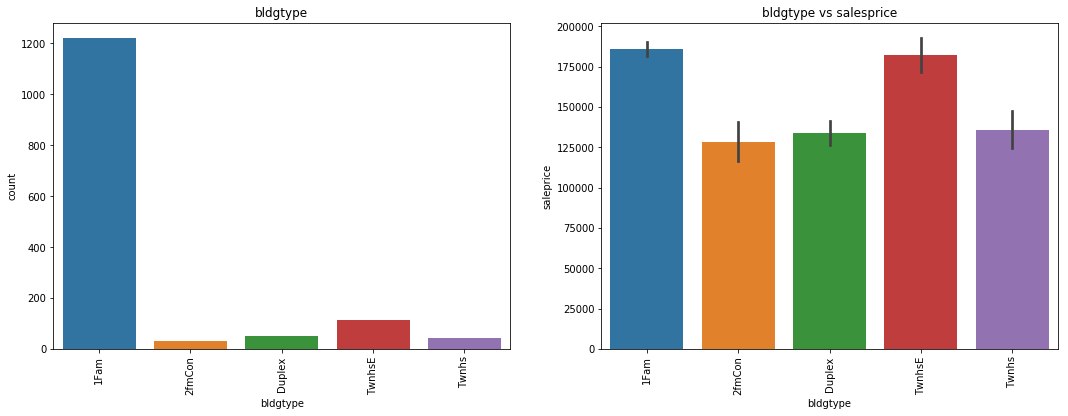

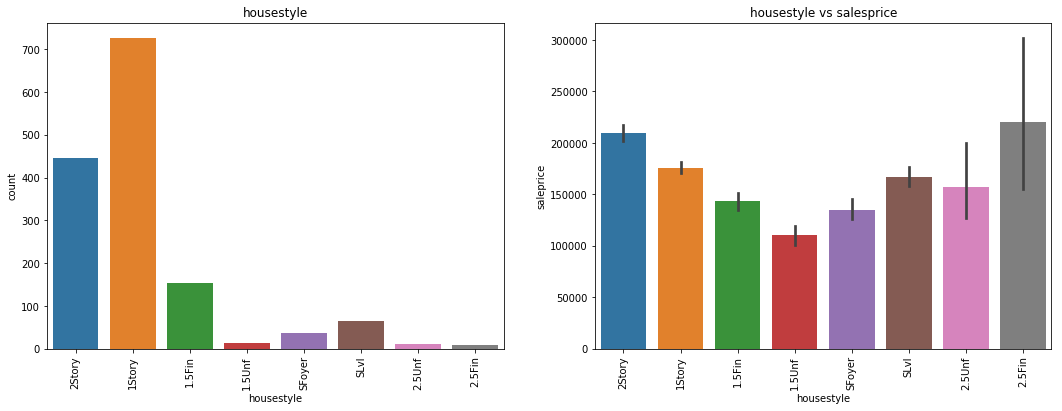

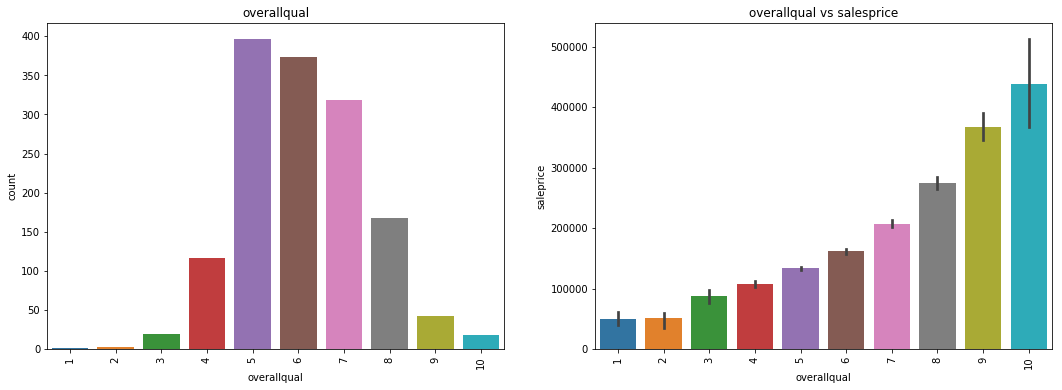

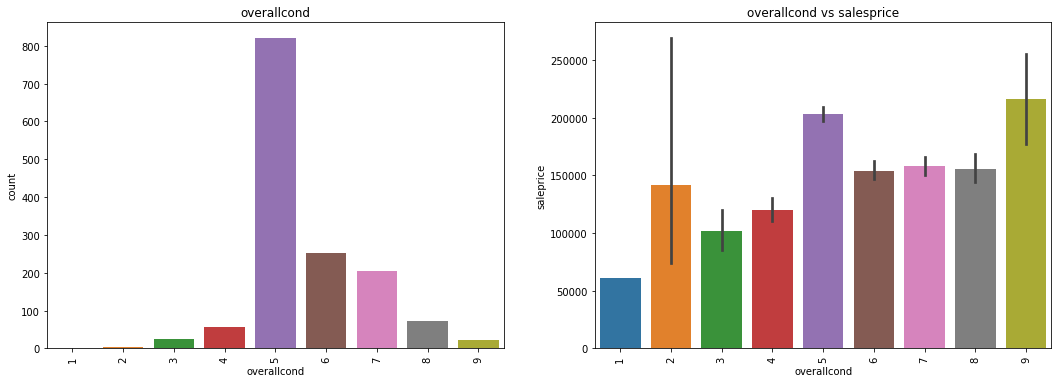

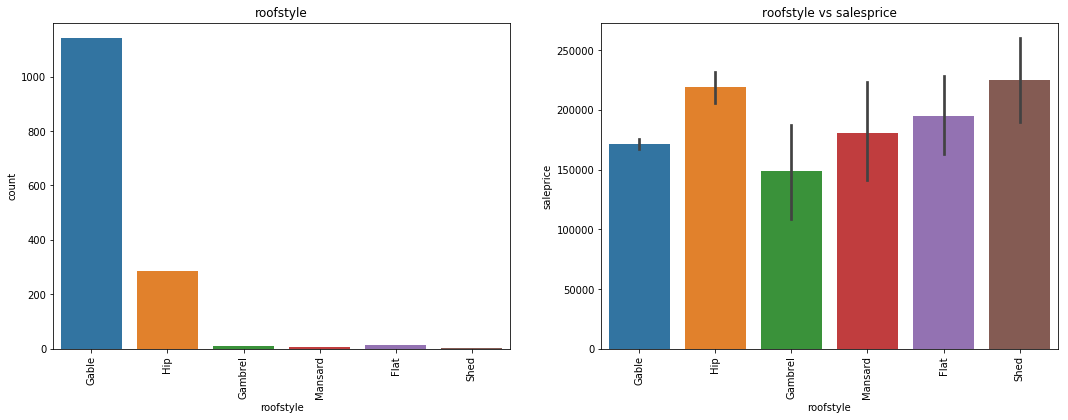

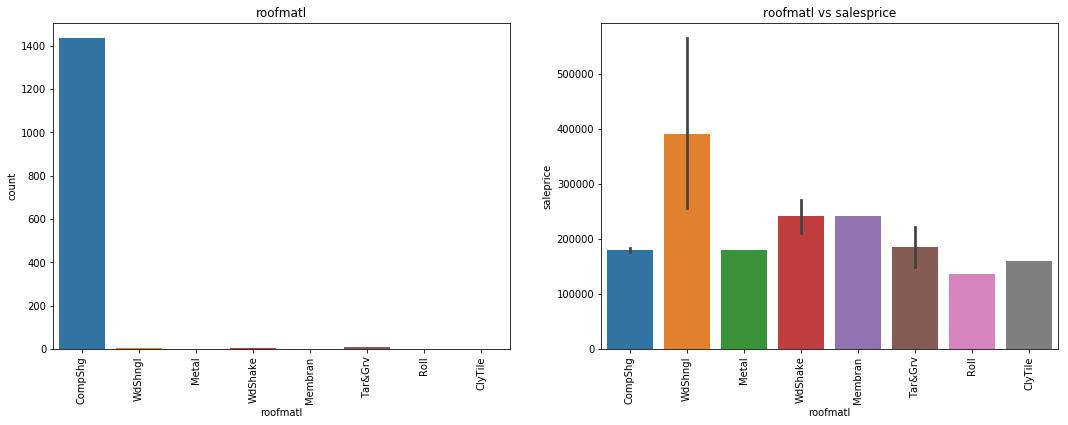

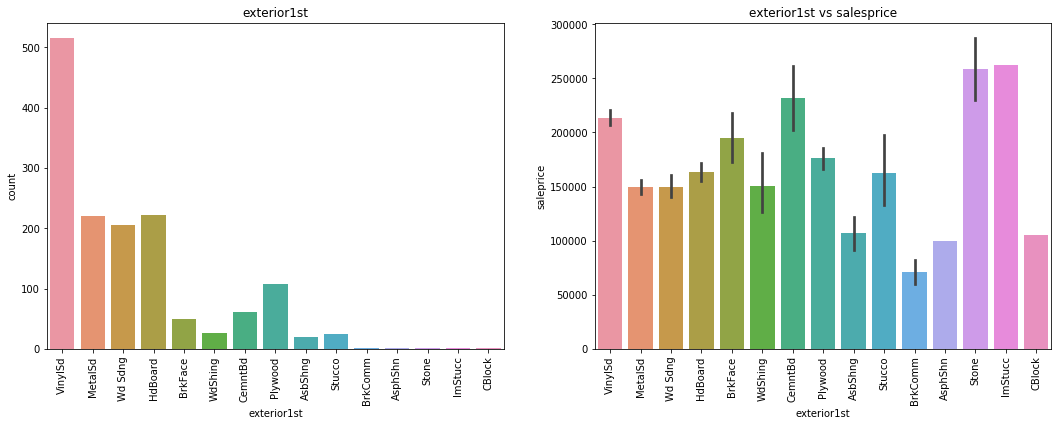

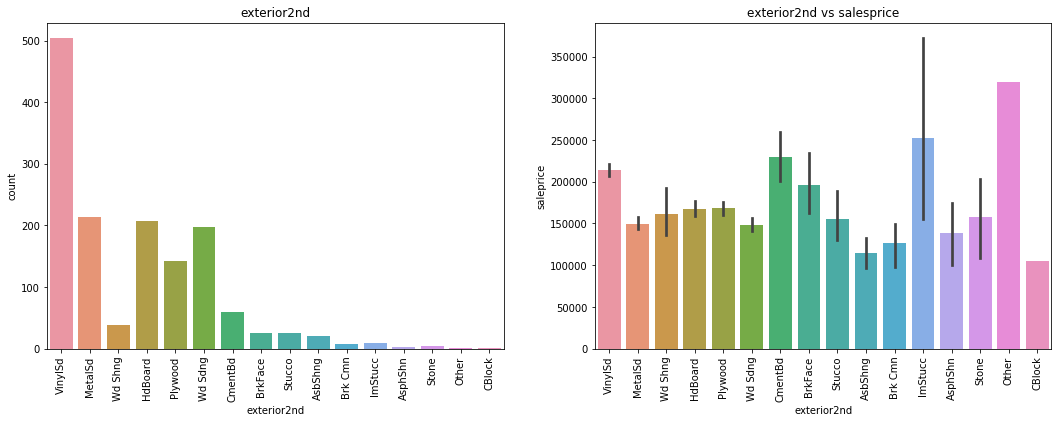

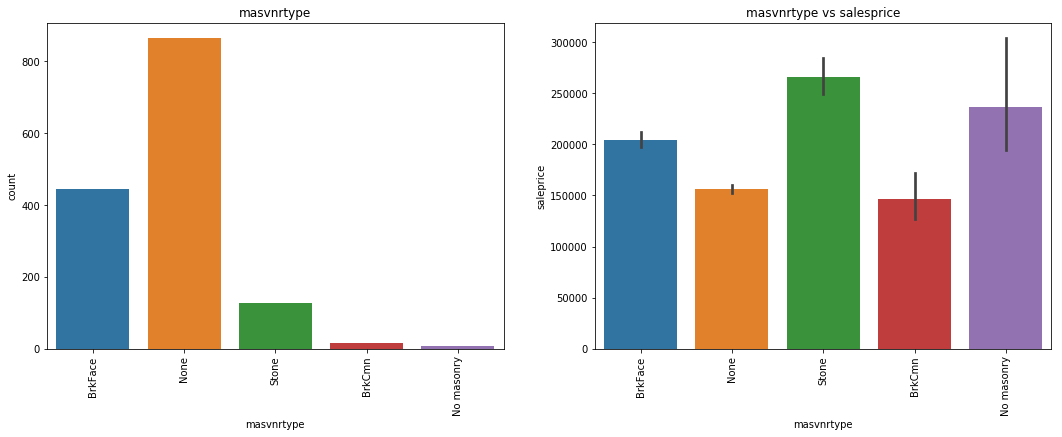

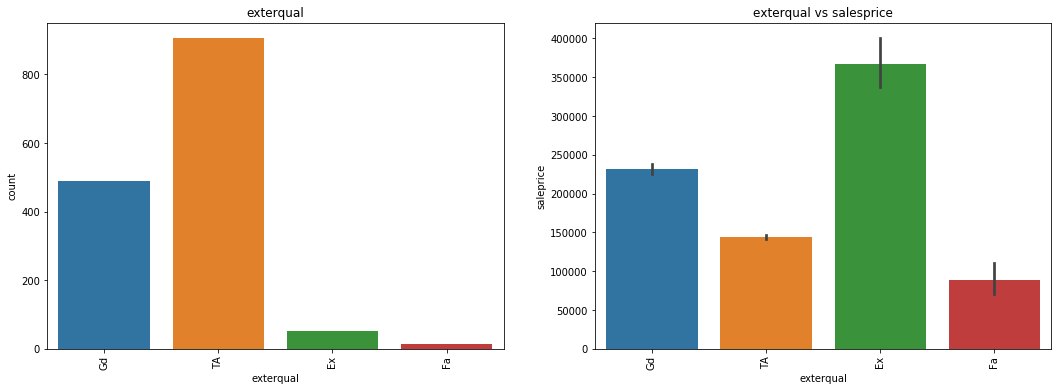

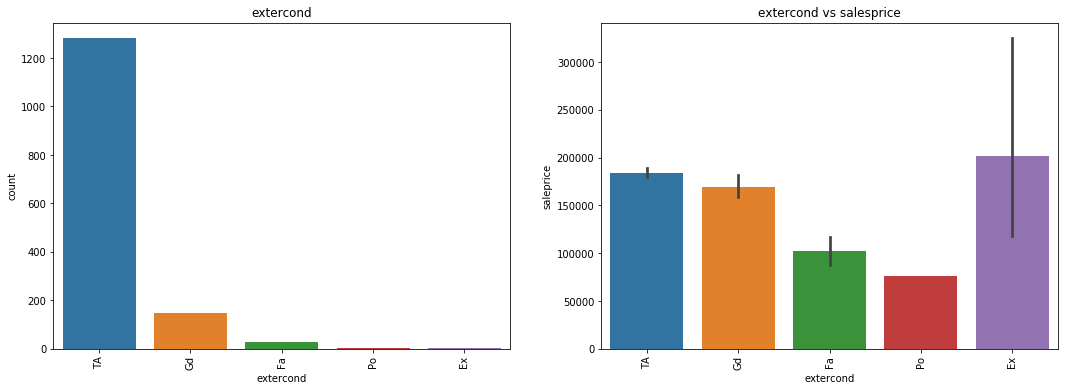

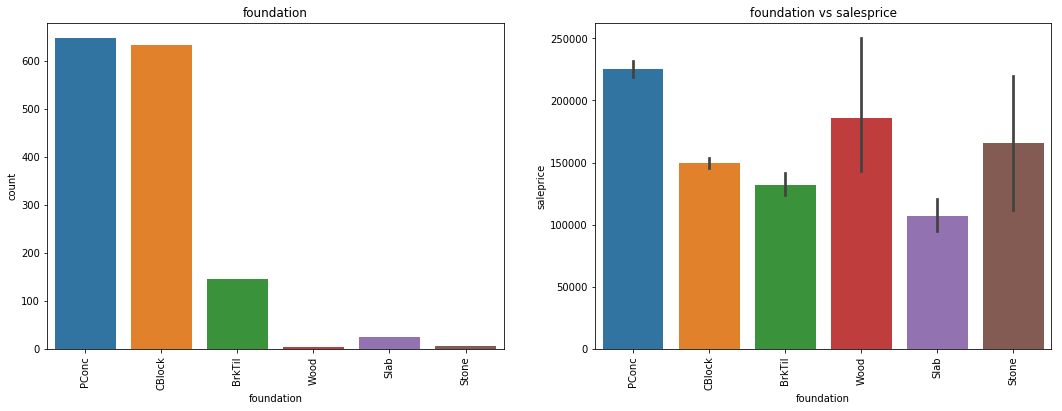

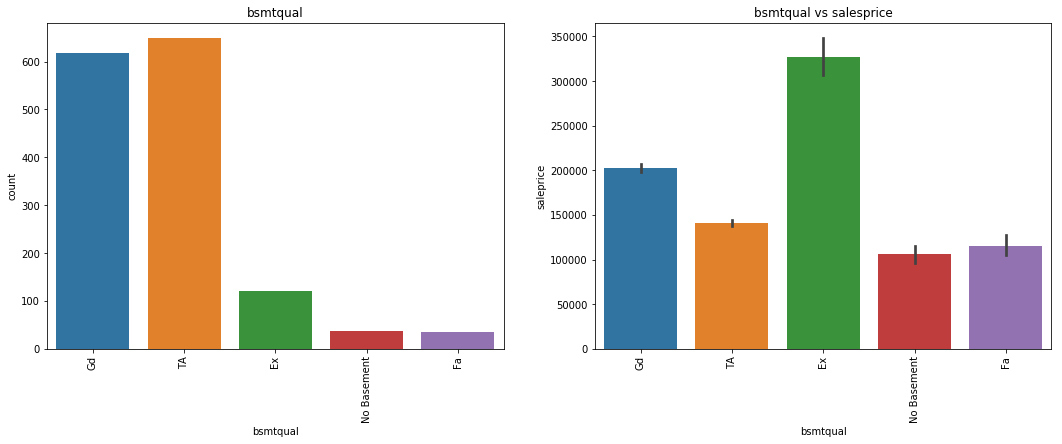

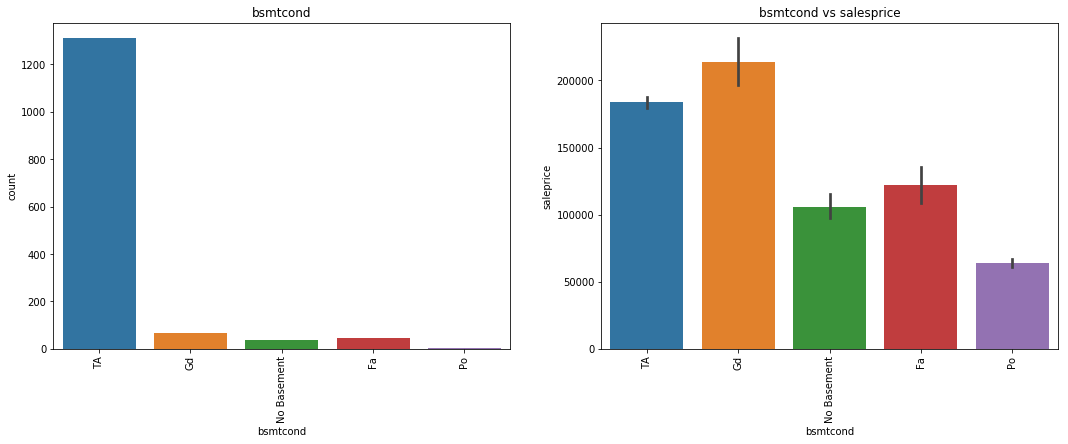

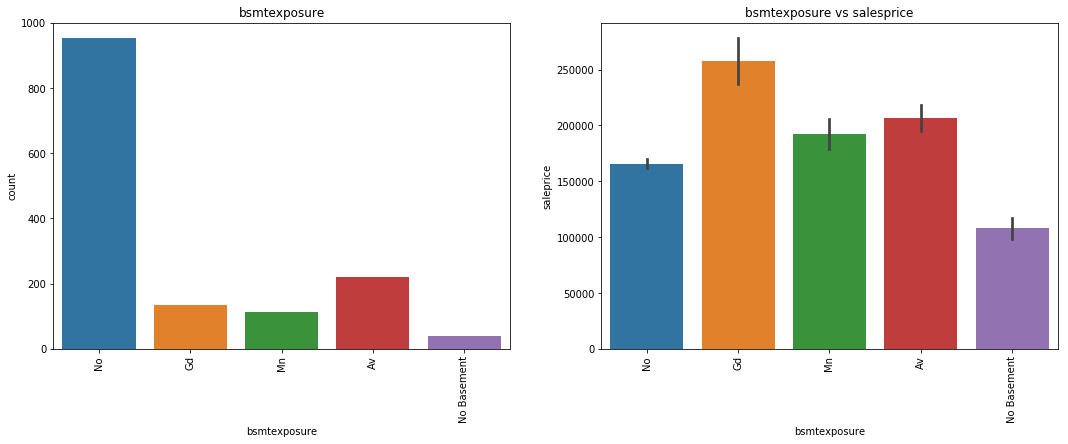

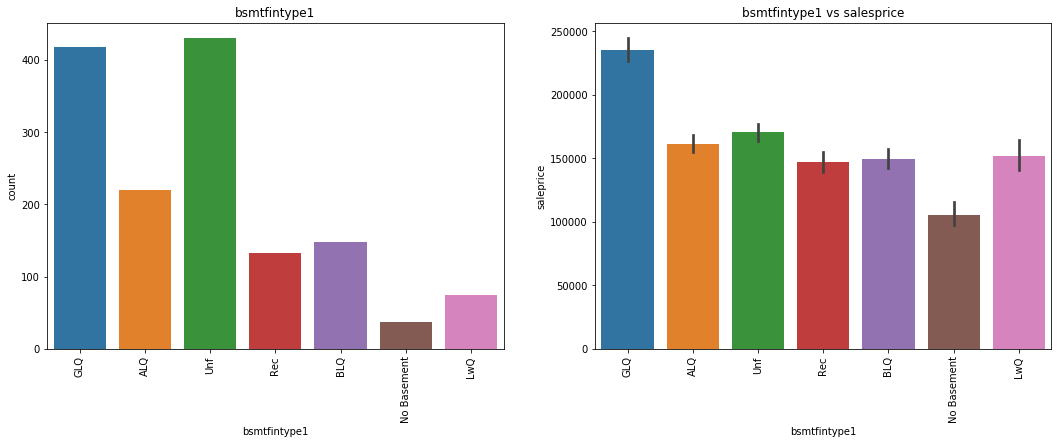

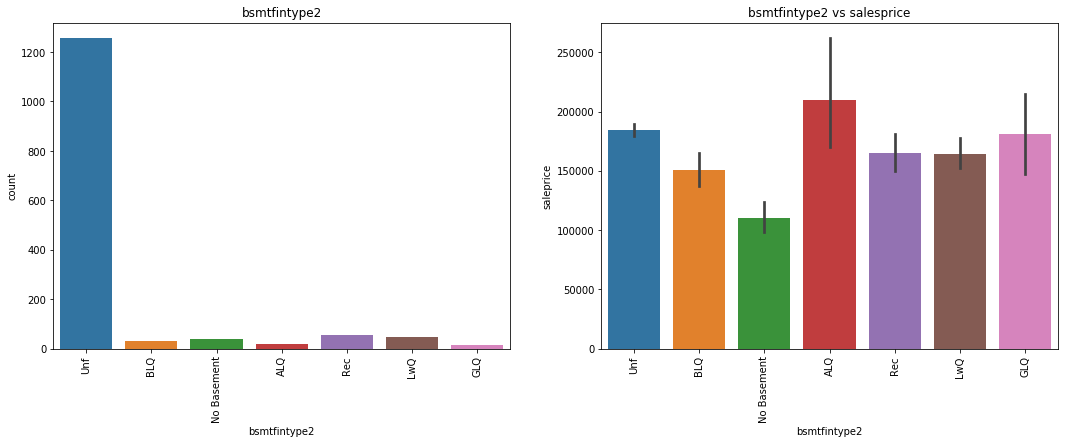

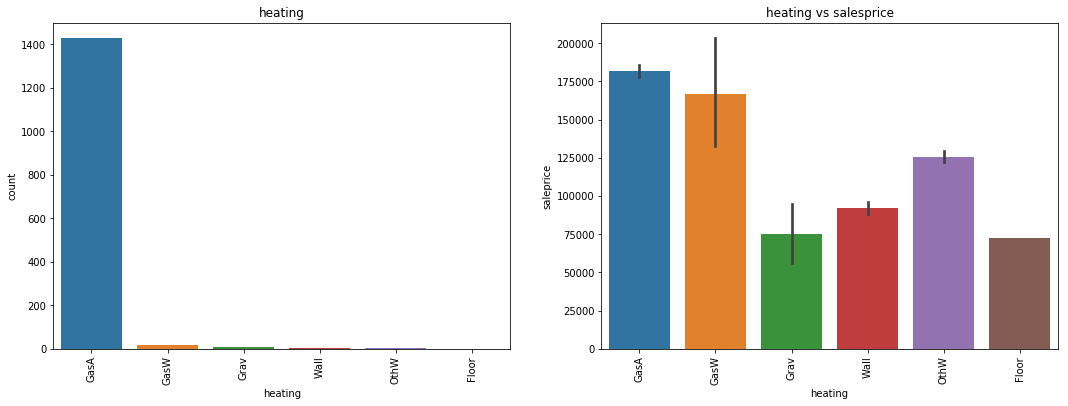

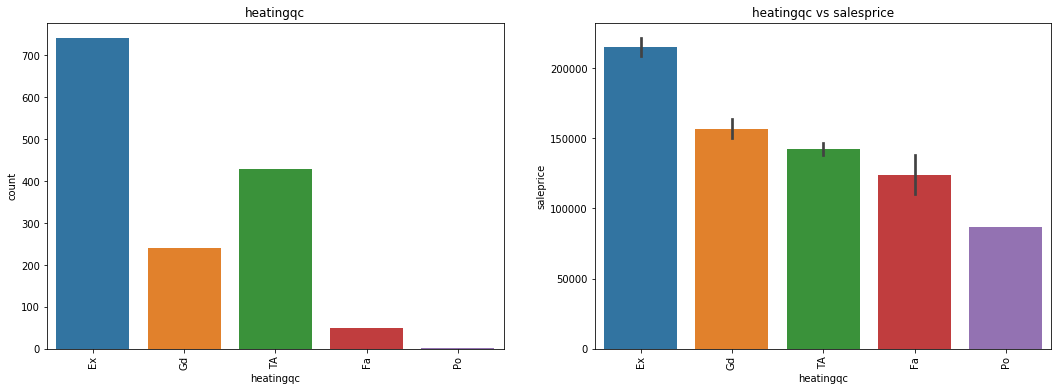

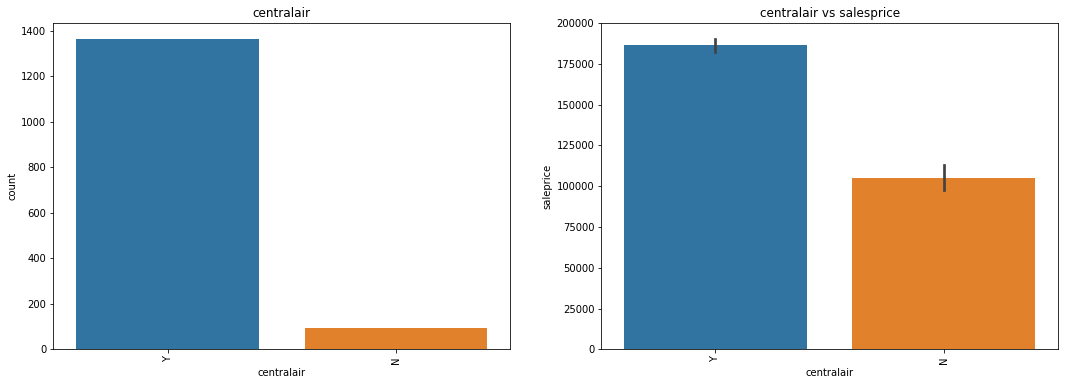

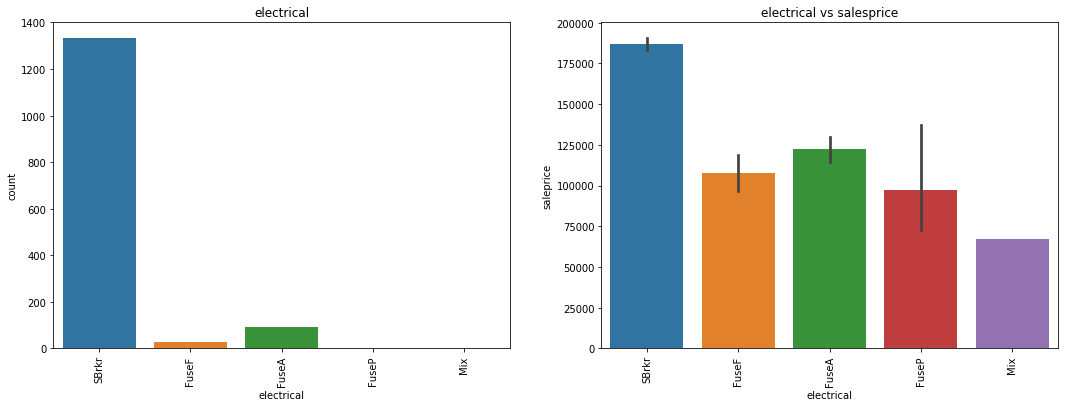

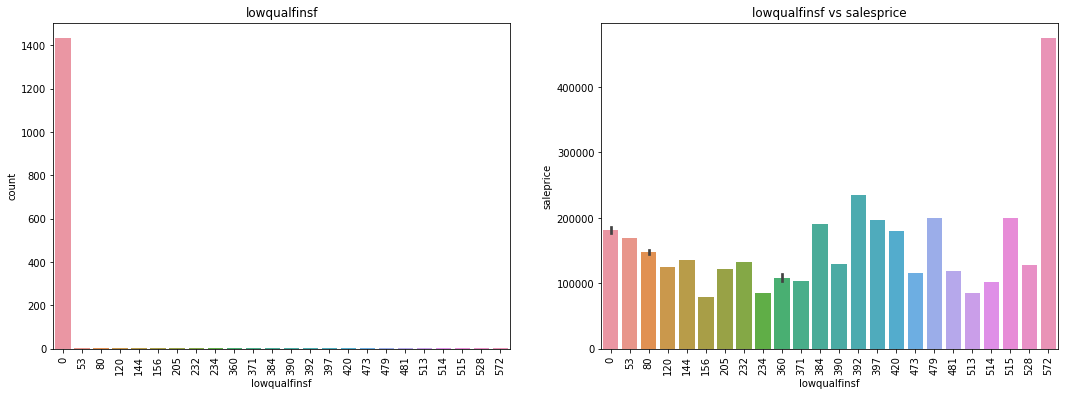

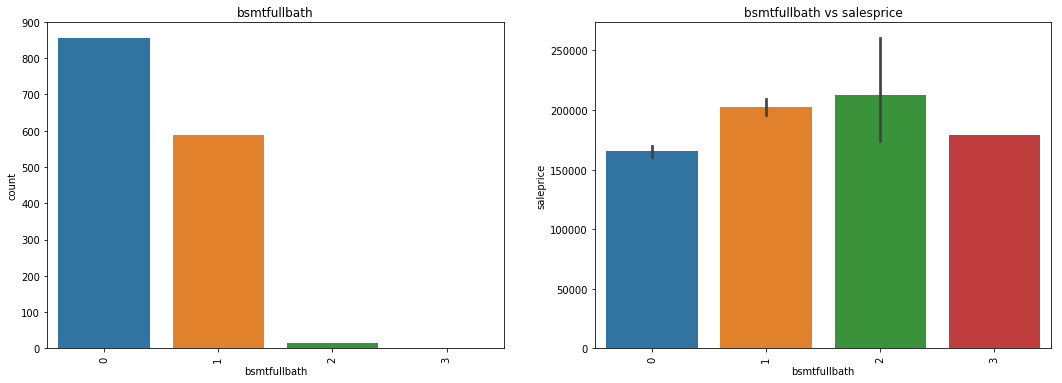

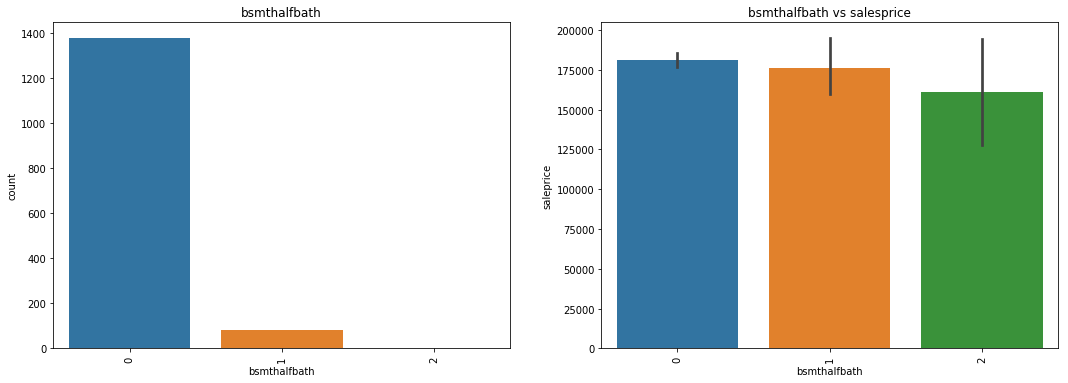

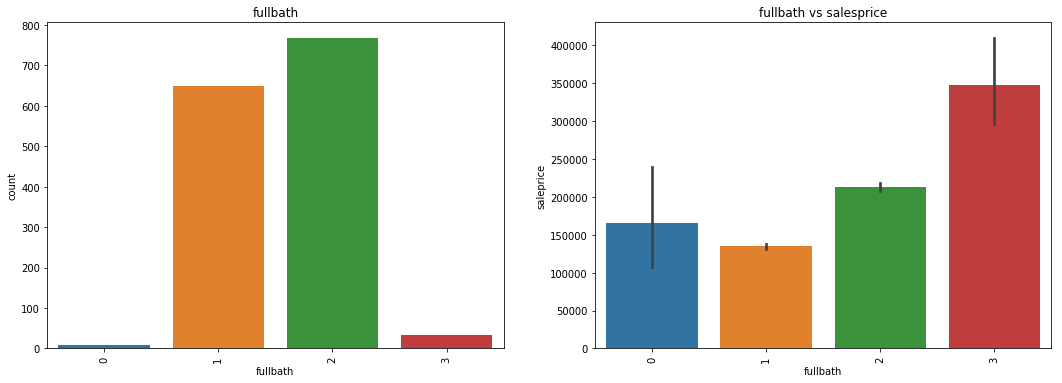

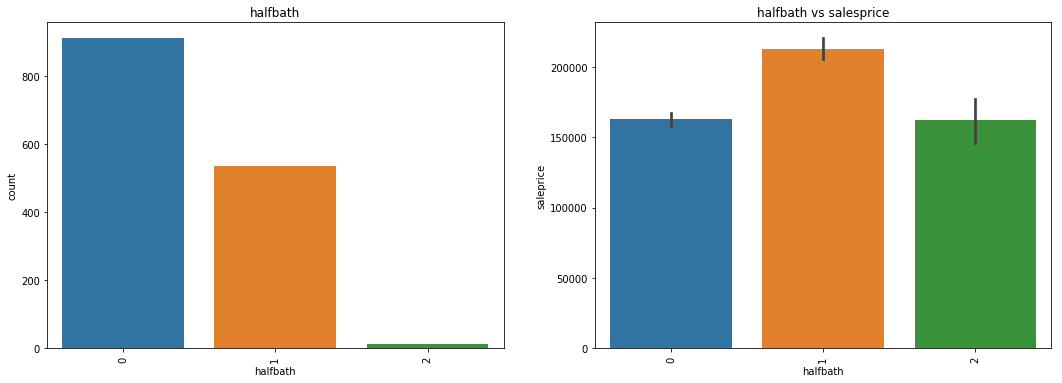

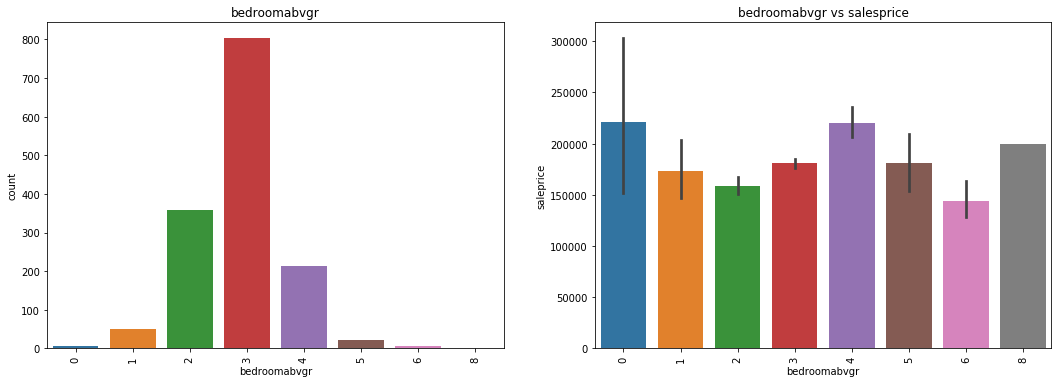

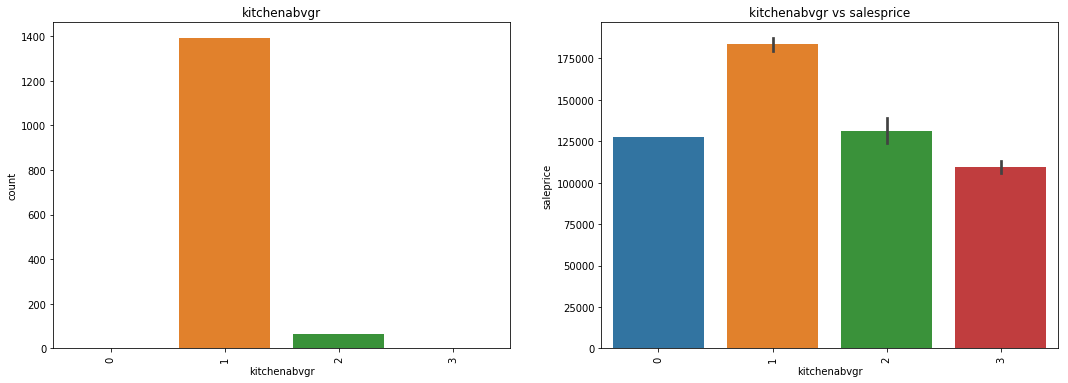

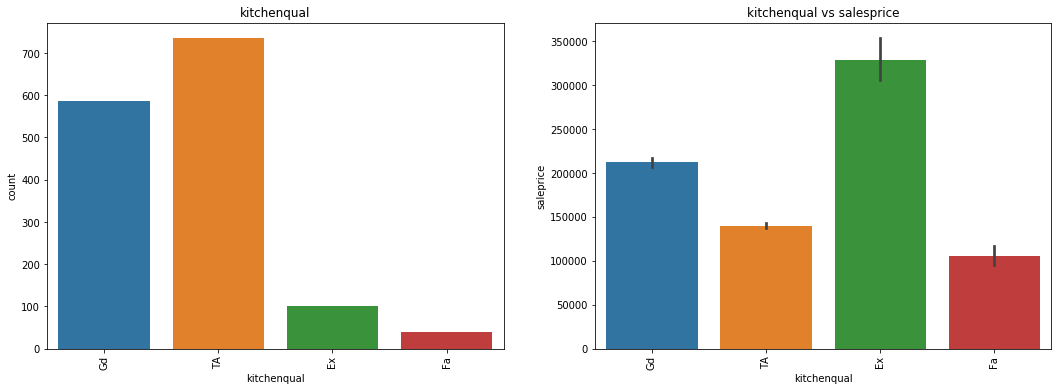

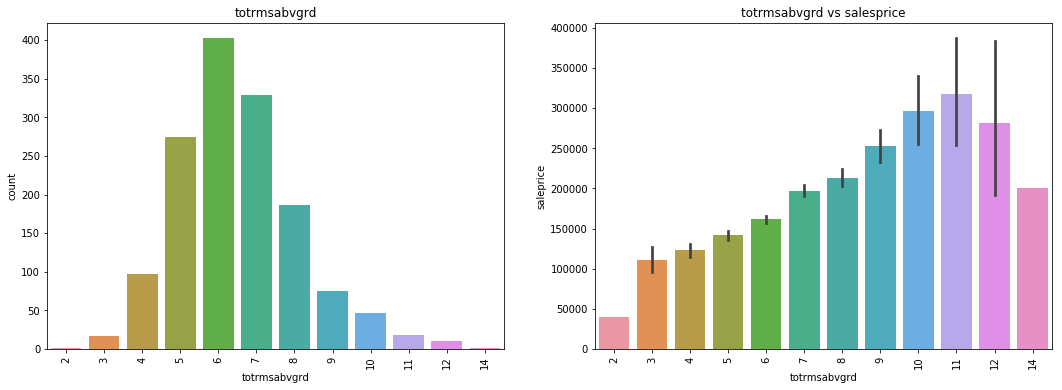

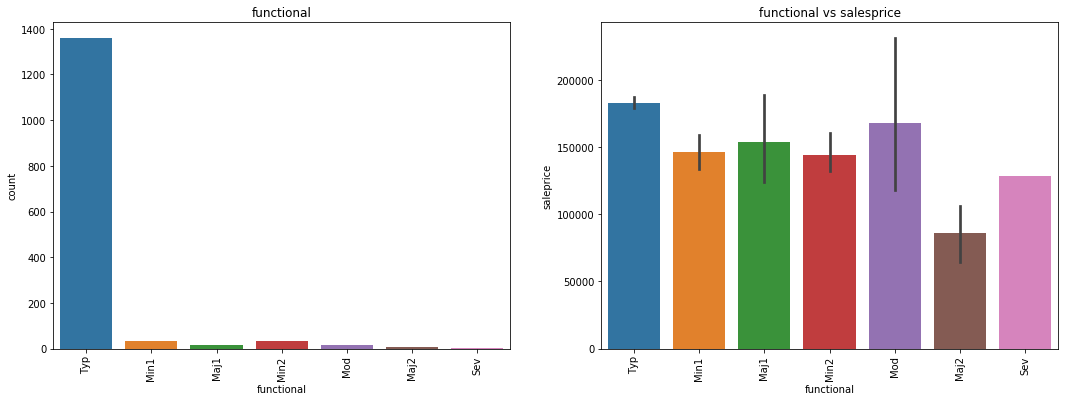

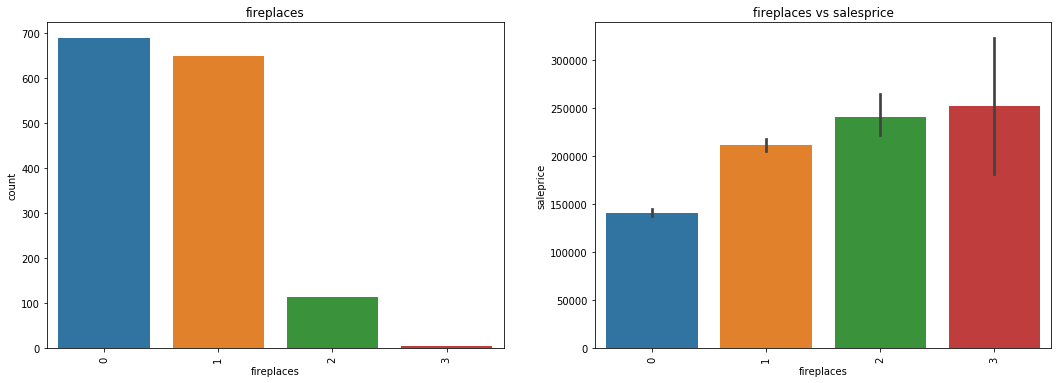

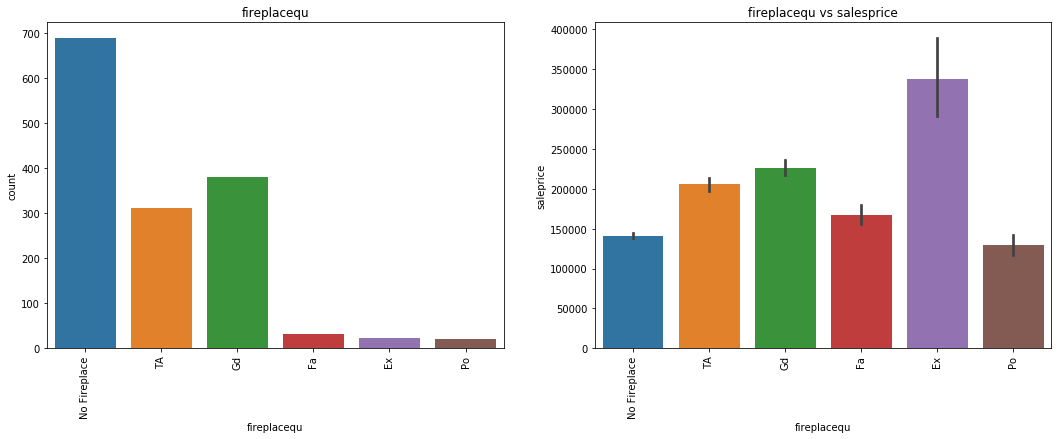

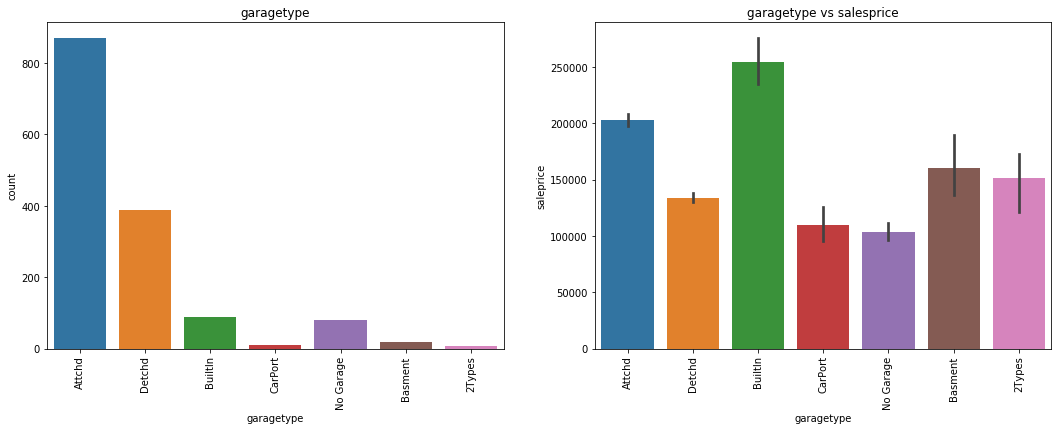

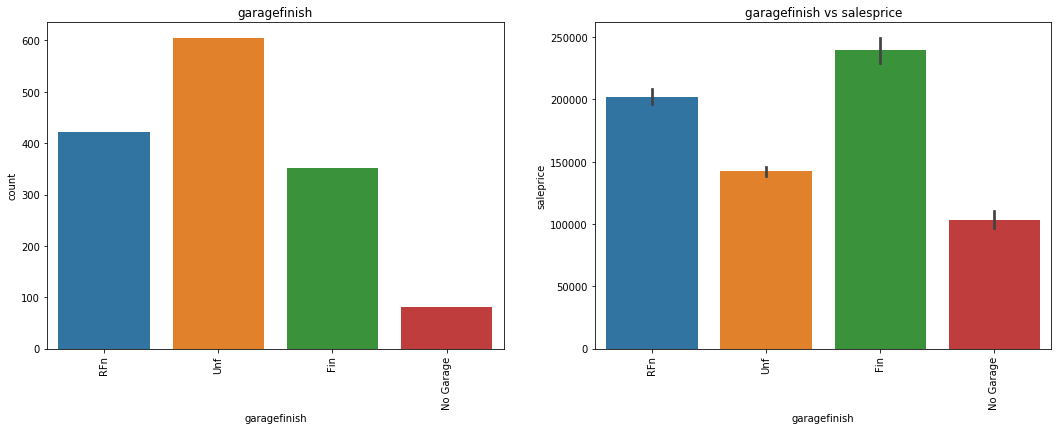

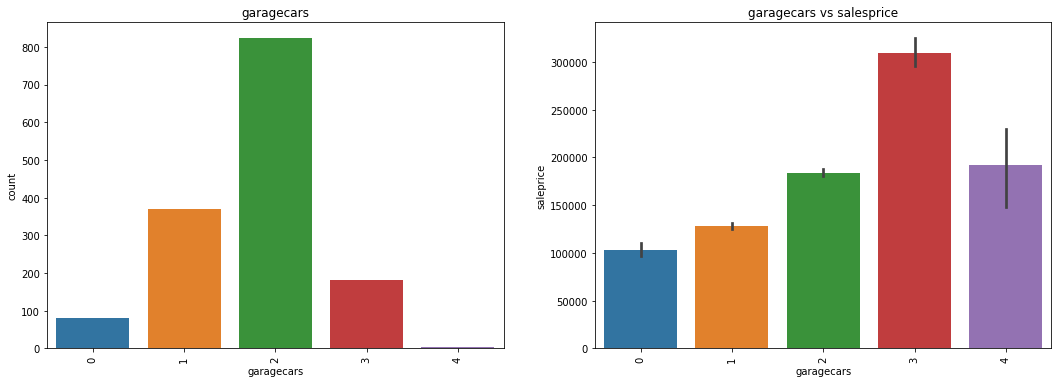

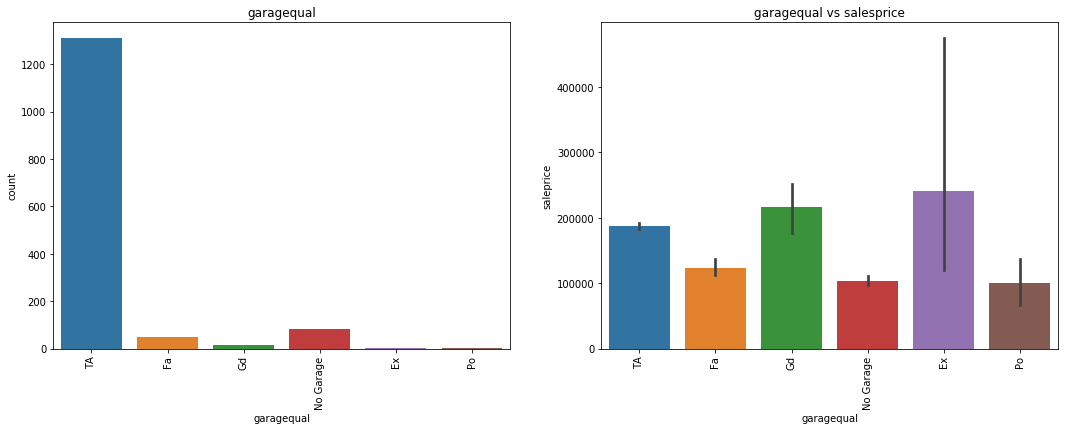

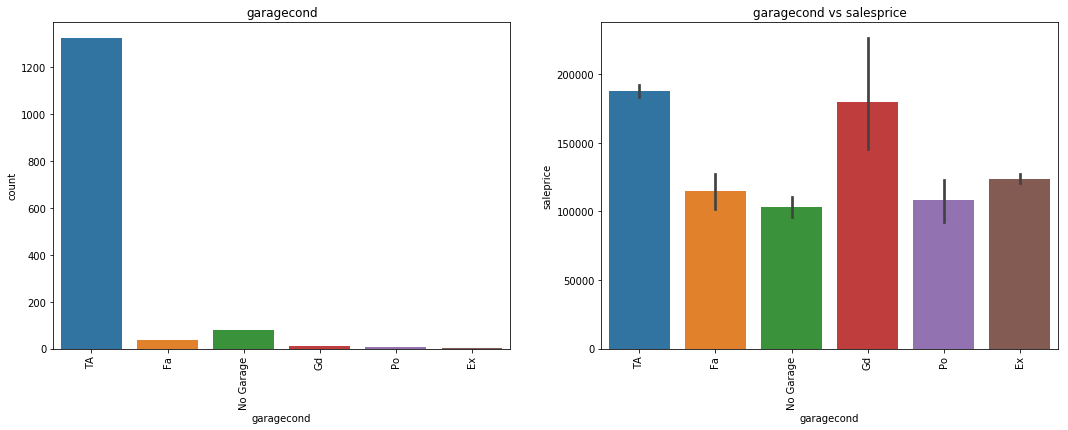

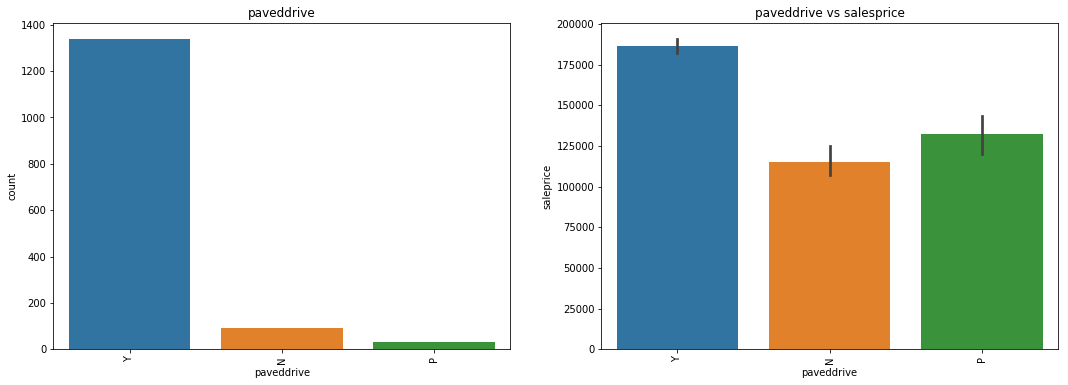

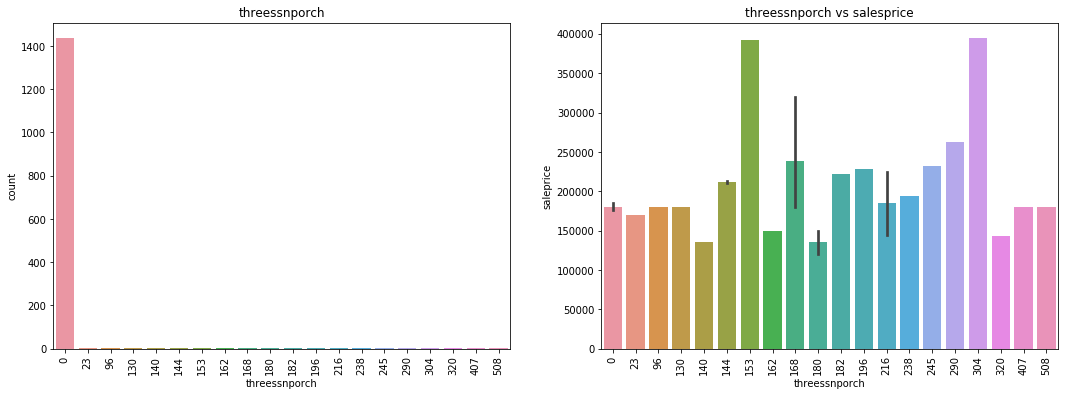

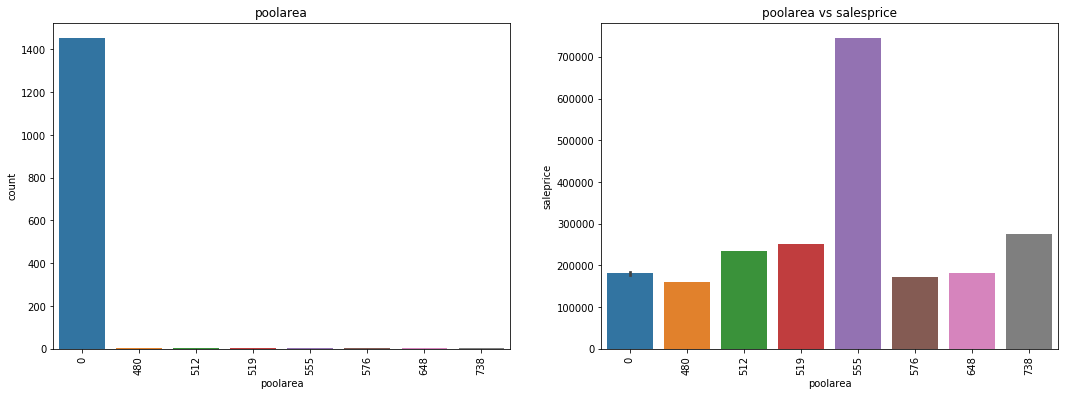

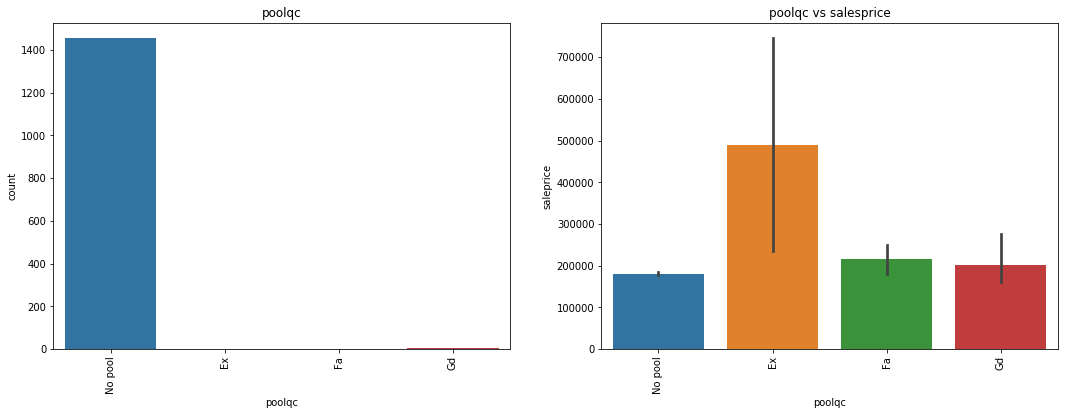

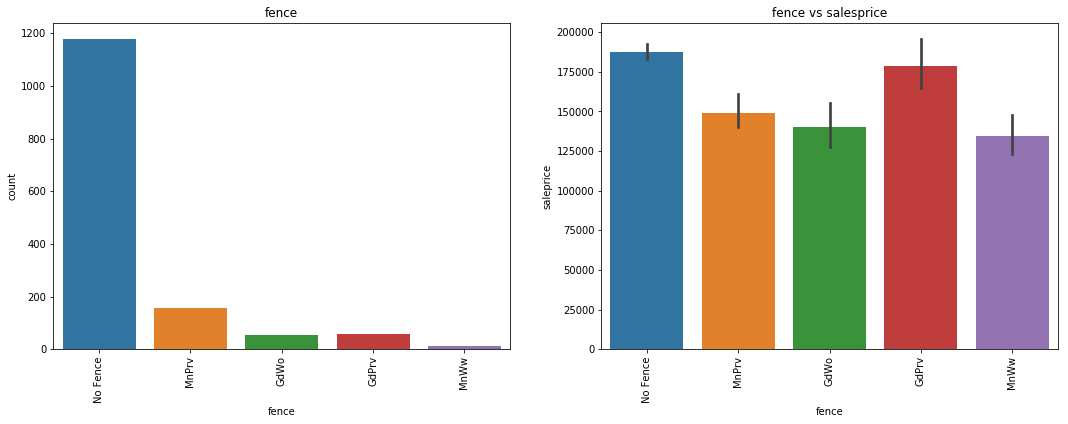

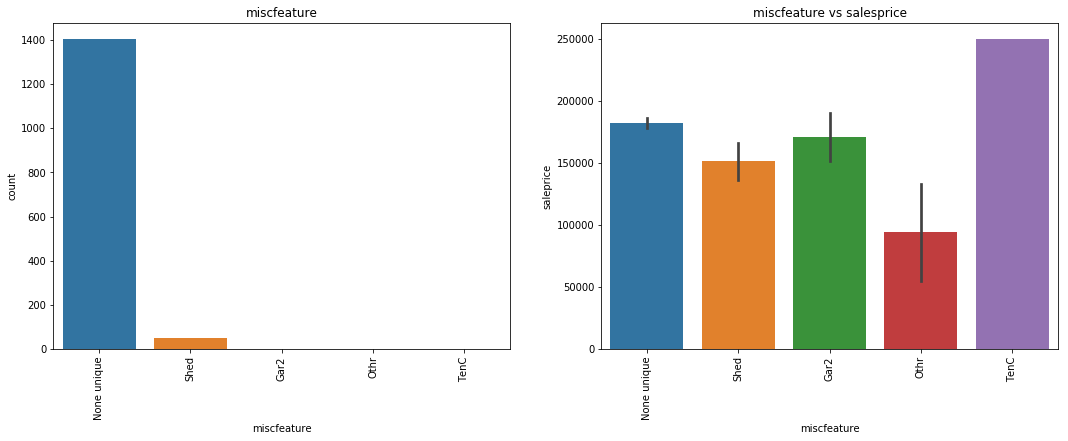

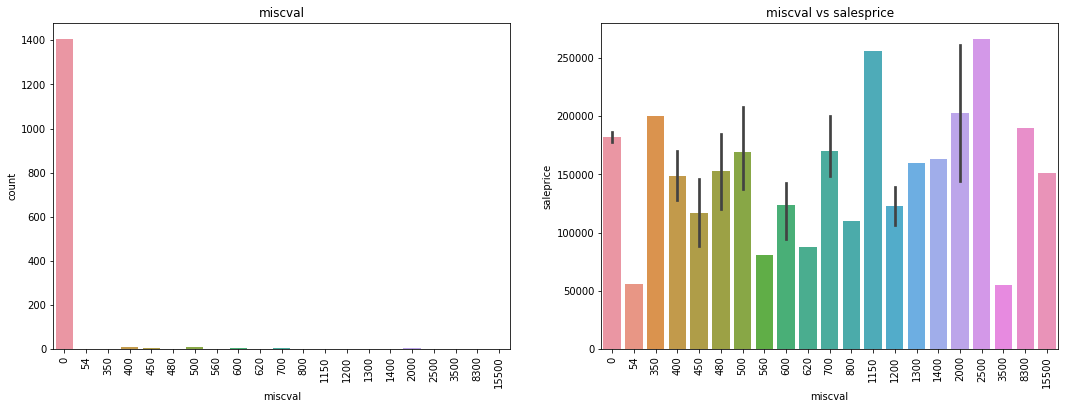

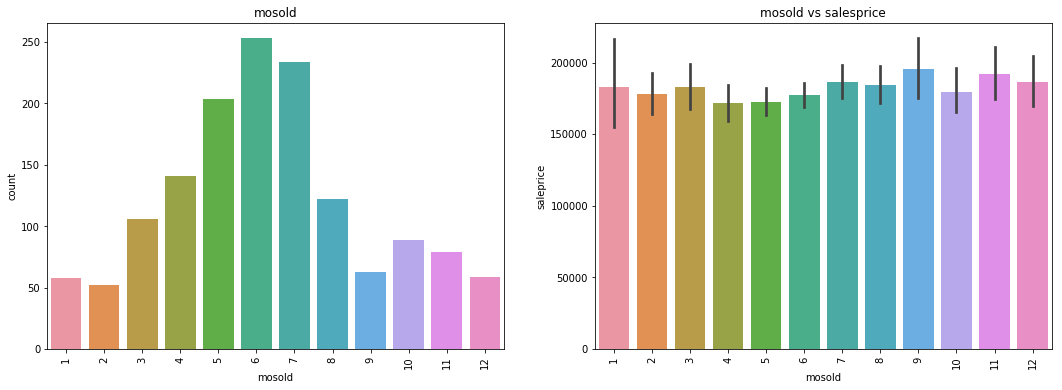

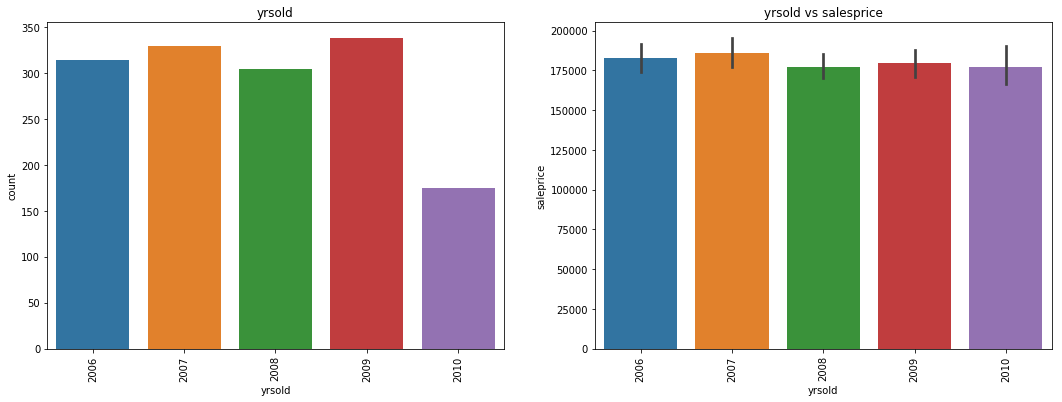

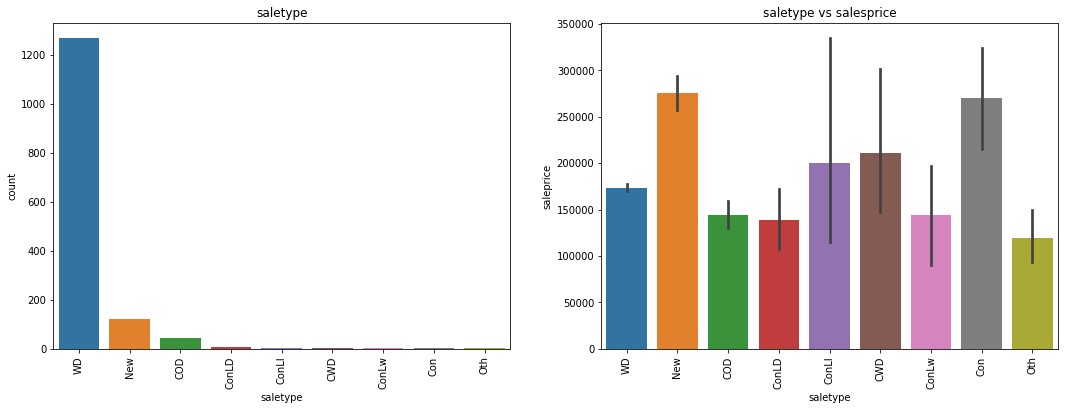

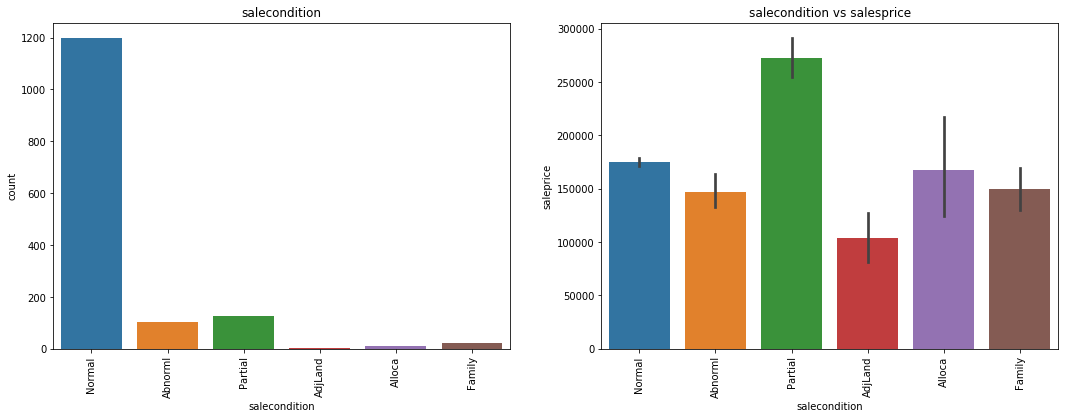

In [10]:
#let's inspect our categorical values
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.title('{}'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='saleprice', data=df)
    plt.title('{} vs salesprice'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.show()

The coefficient is 0.33477085313975996


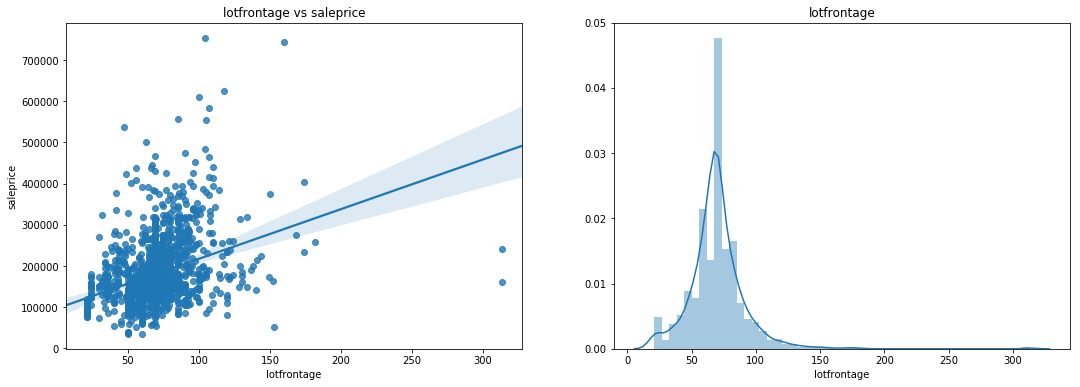

The coefficient is 0.2638433538714056


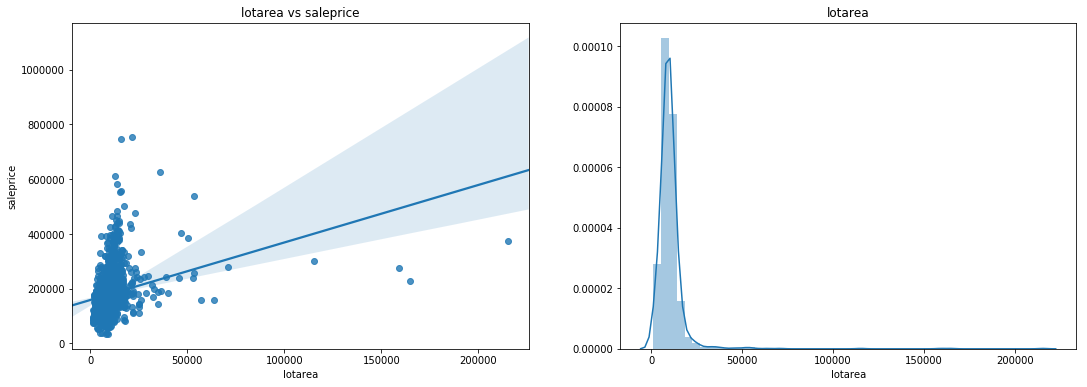

The coefficient is 0.522897332879497


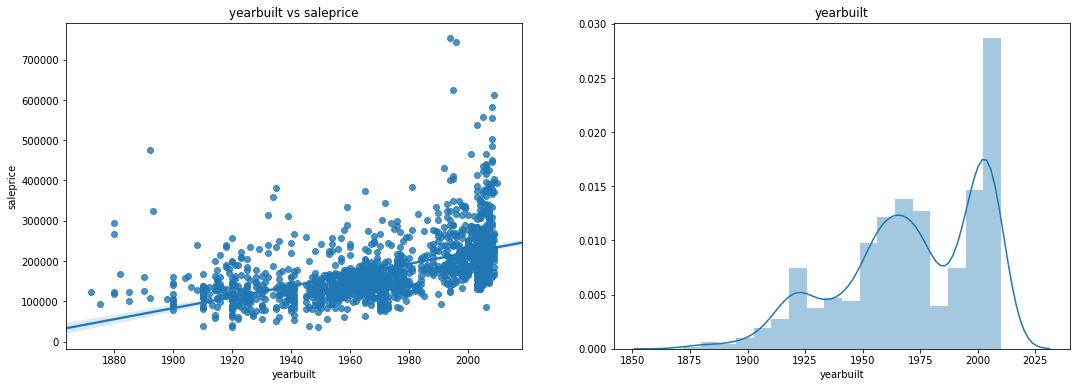

The coefficient is 0.5071009671113861


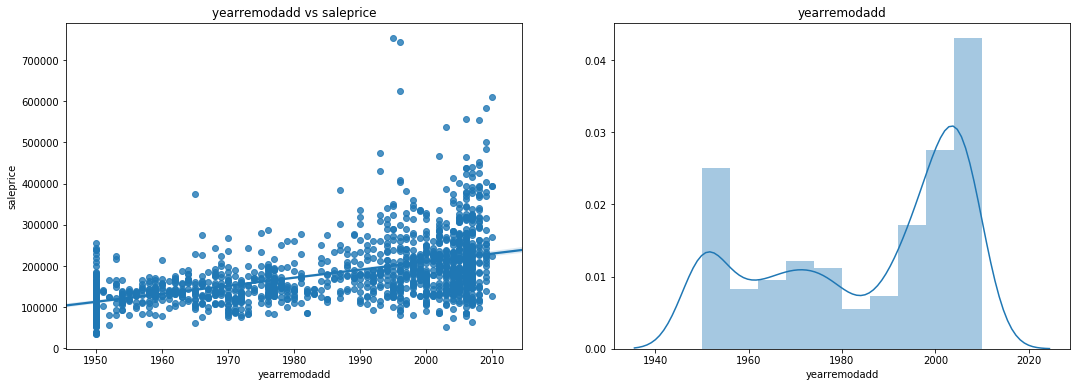

The coefficient is 0.4726144990045737


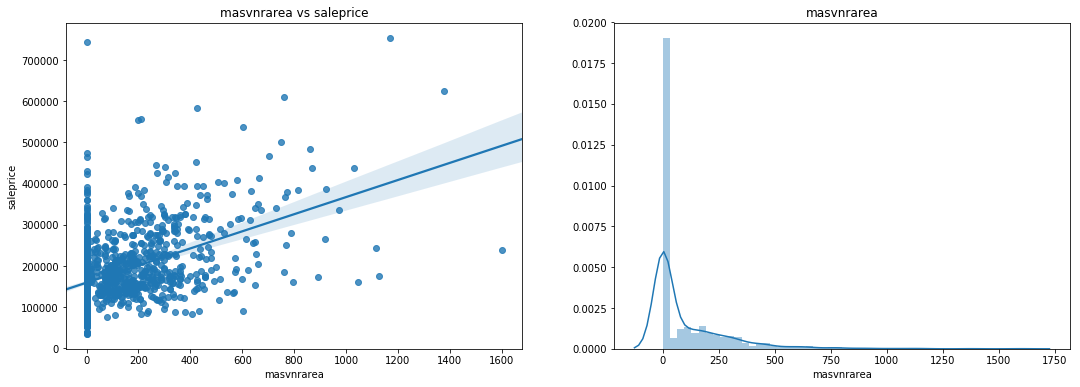

The coefficient is 0.3864198062421533


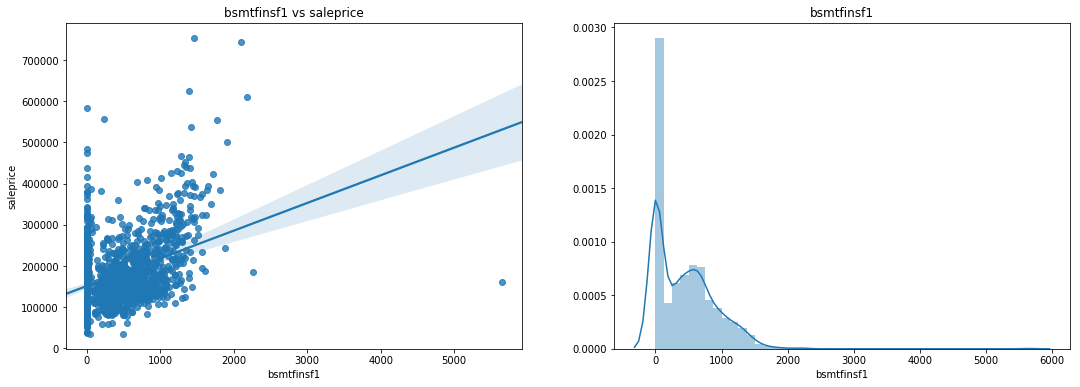

The coefficient is -0.01137812145021514


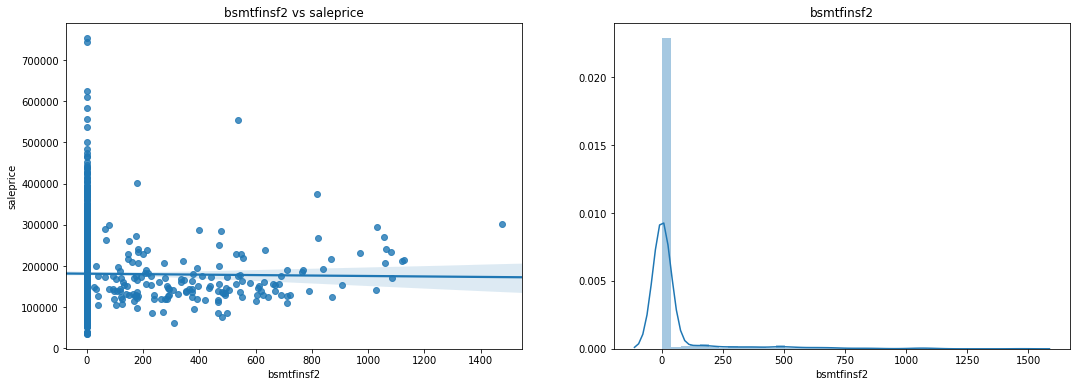

The coefficient is 0.2144791055469689


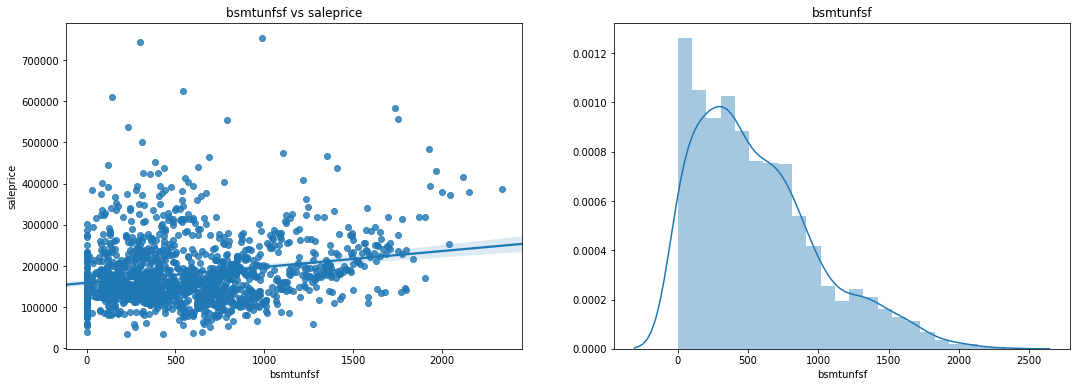

The coefficient is 0.6135805515591953


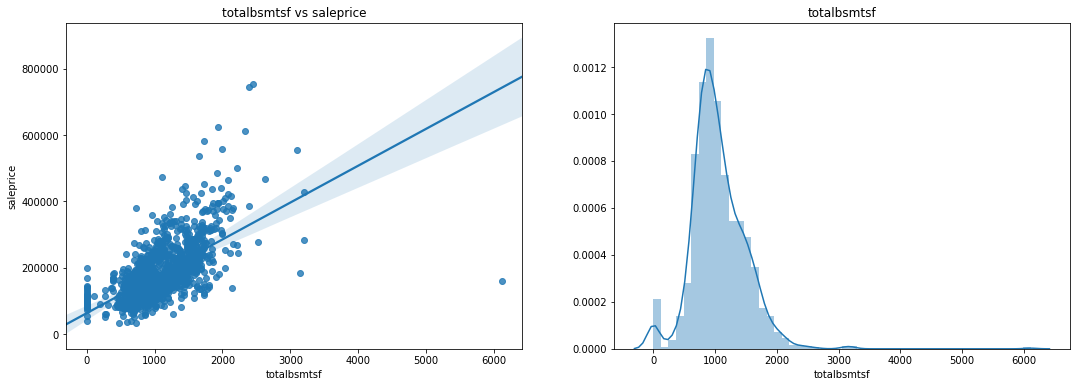

The coefficient is 0.6058521846919147


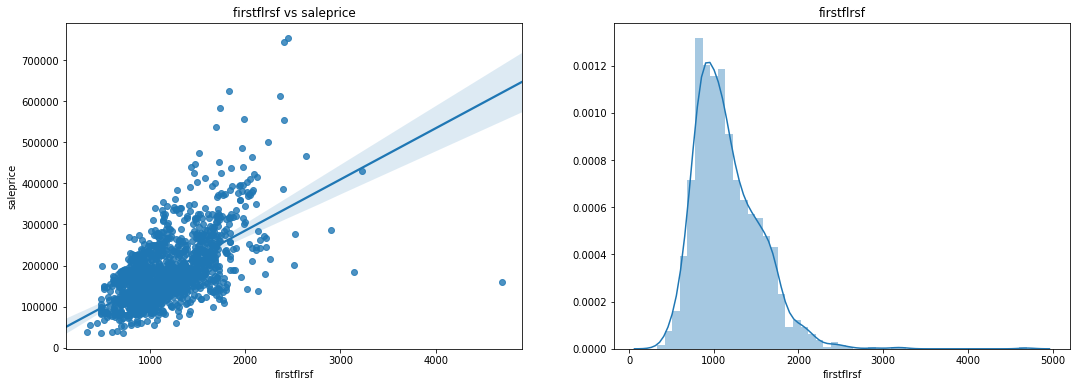

The coefficient is 0.3193338028320678


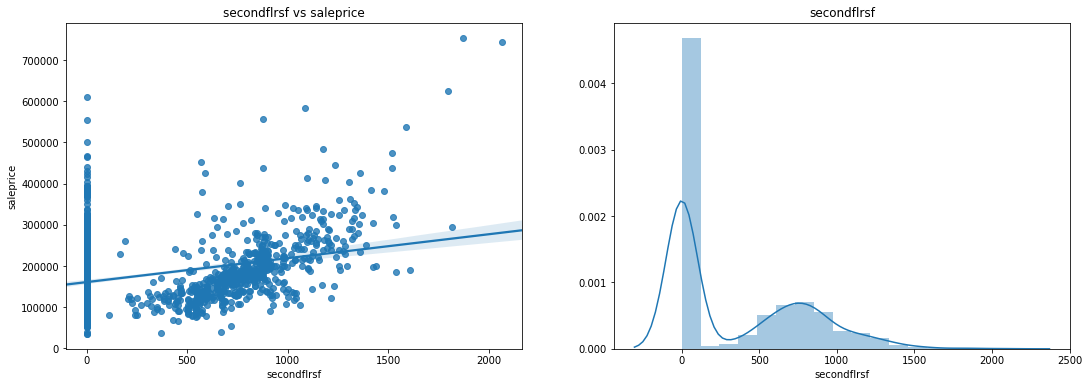

The coefficient is 0.708624477612652


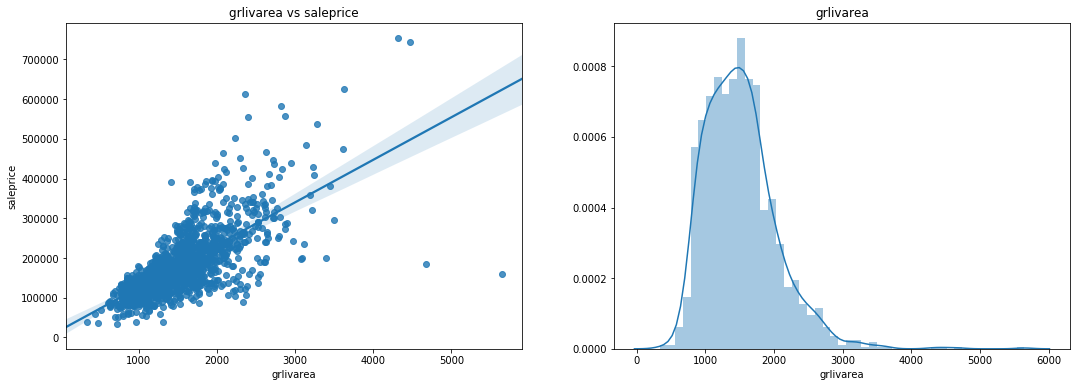

The coefficient is 0.6234314389183616


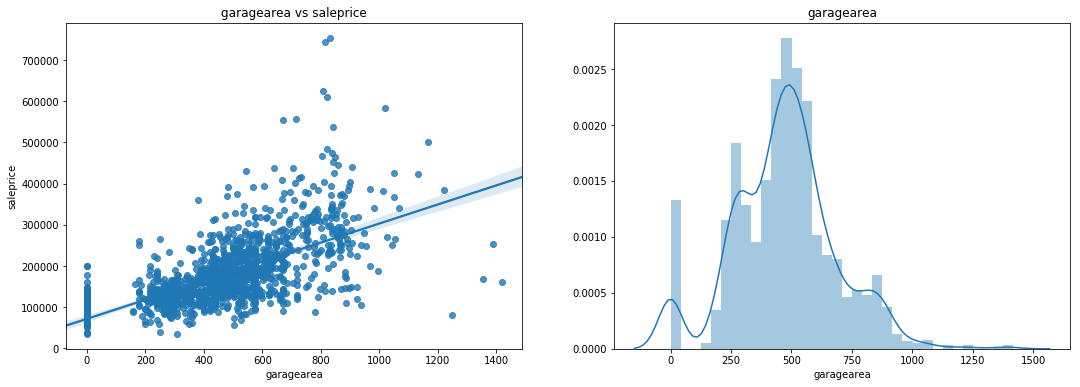

The coefficient is 0.3244134445681299


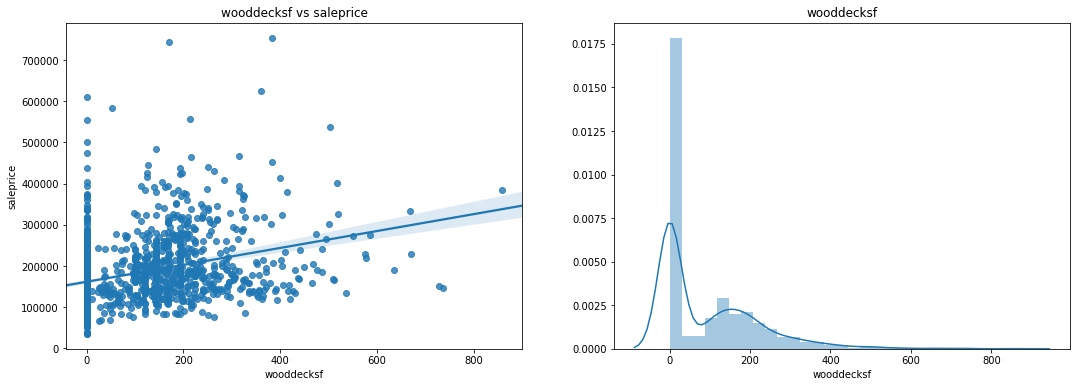

The coefficient is 0.3158562271160552


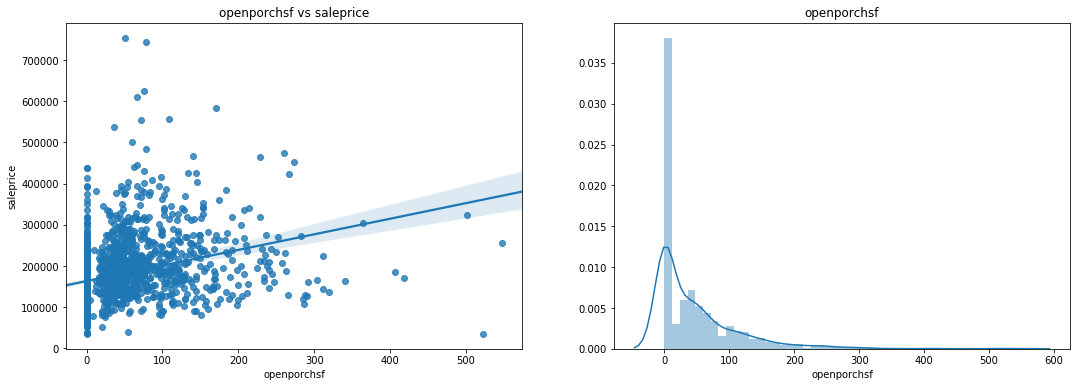

The coefficient is -0.12857795792595675


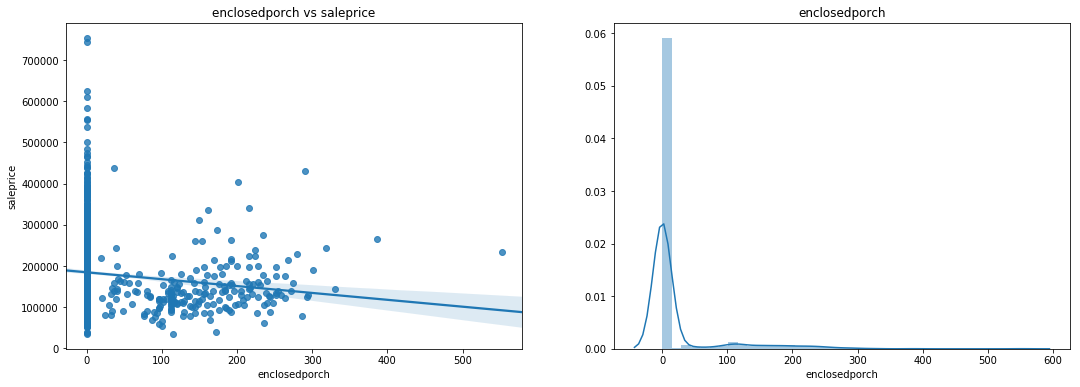

The coefficient is 1.0


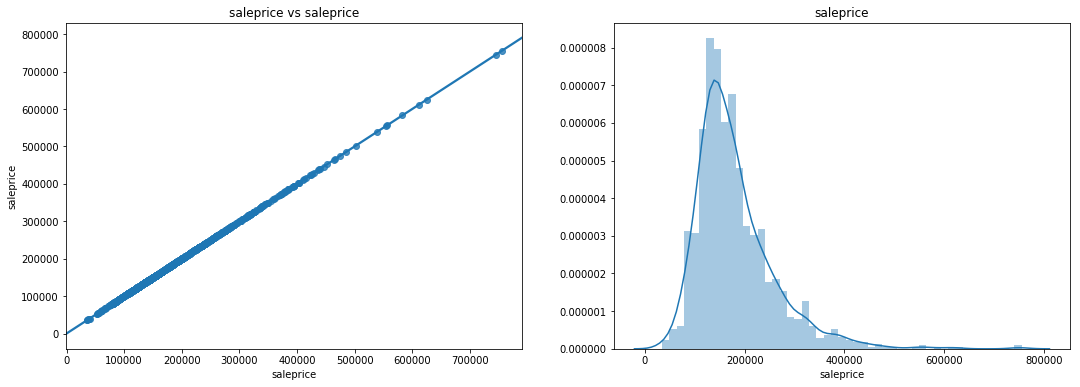

The coefficient is 0.11144657114291123


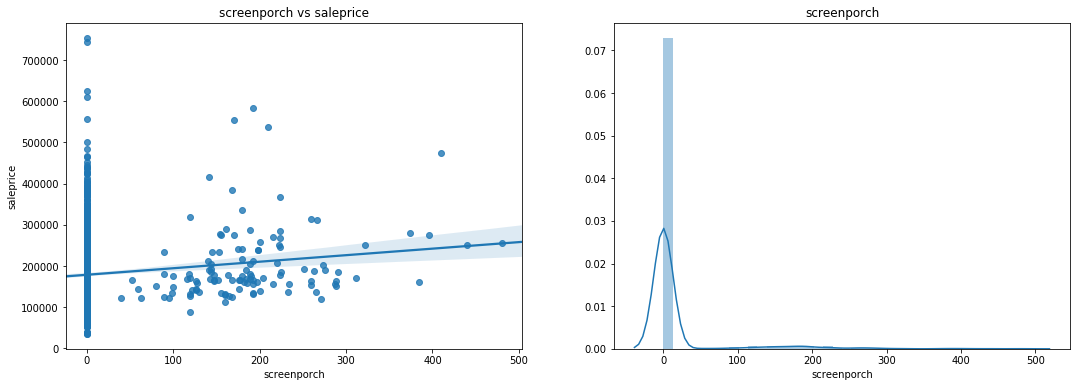

In [11]:
for column in cont_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    corr, p_value = stats.pearsonr(df['saleprice'], df[column])
    print('The coefficient is {}'.format(corr))
    sns.regplot(x=column, y='saleprice', data=df)
    plt.title('{} vs saleprice'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    
    plt.show()

In [12]:
#create our continuous dataframe
cont_df = df[['totalbsmtsf', 'firstflrsf', 'grlivarea', 'garagearea', 'saleprice']]

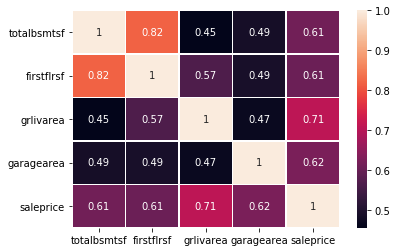

In [13]:
sns.heatmap(cont_df.corr(), annot=True, linewidth=0.5)
plt.show()

In [14]:
#drop firstflrsf
cont_df = cont_df.drop(columns='firstflrsf')

In [15]:
#we only have 1 cat_df that needs get_dummies
dummies = pd.get_dummies(df['kitchenqual'])
#create our categorical df
cat_df = pd.concat([dummies, df.overallqual, df.totrmsabvgrd, df.fireplaces, df.garagecars], axis=1)

In [16]:
#combine the 2 dataframes
final_df = pd.concat([cont_df, cat_df], axis=1)

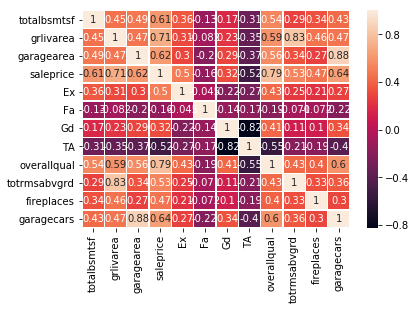

In [17]:
sns.heatmap(final_df.corr(), annot=True, linewidth=0.5)
plt.show()

Those look pretty good, let's start building our OLS lr model!

In [24]:
X = final_df.drop(columns='saleprice')
y = final_df['saleprice']

In [30]:
lrm = linear_model.LinearRegression()

lrm.fit(X, y)

print('Coefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

Coefficients: 
 [ 2.51294155e+01  4.20730065e+01  1.33791554e+01  4.30044096e+04
 -1.81810941e+04 -4.81066985e+03 -2.00126456e+04  1.74803144e+04
 -4.21608747e+02  8.87268769e+03  1.39603928e+04]

Intercept: 
 -40172.50241082793


Ok, model built! I'm sure we'll learn how to evaluate it soon...